## TIES relative binding free energy application

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the TIES application. Small variation in the results will occur due to the stochastic nature of the training procedure.

### Reference

*Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [1]:
#!pip install easysurrogate==0.24.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [3]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [4]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

### Load prior ranges
The JSON files below contains all default values and boundaries used for specifying the Uniform input parameter distributions.

In [5]:
# # Load the EasyVVUQ params dicts, containing the default values and type of each input
# priors = {}
# # there are 5 inputs files, each with a seperate params dict
# prior_fnames = os.listdir('./priors')
# for fname in prior_fnames:
#     print(fname)
#     prior = json.load(open('./priors/%s' % fname, 'r'))
#     priors = priors | prior
# priors

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [6]:
# input parameters
params = pd.read_csv('./data_ties/ties_inputs.csv')
param_names = params.keys()
params = params.values

n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

# p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
# p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])

# # except the temperature
# idx_T = np.where(param_names == 'setTemperature')[0]
# p_max[idx_T] = np.array(priors['setTemperature']['default'] * 1.075)
# p_min[idx_T] = np.array(priors['setTemperature']['default'] * 0.925)

p_min = np.min(params, axis=0)
p_max = np.max(params, axis=0)

# scale inputs within [-1, 1]
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

In [7]:
print('There are %d inputs' % D)

There are 169 inputs


### Load output samples

Load the corresponding Monte Carlo outputs, in the case the binding free energy predictions.

In [8]:
QoI = 'relative_binding_energy'
output = pd.read_csv('./data_ties/%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [9]:
average_over_replicas = True

if not average_over_replicas:
    samples = output[:, 2].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [10]:
########################################
# choose the active subspace dimension #
########################################
d = 1

### Hyperparameters

In [11]:
# number of neurons per hidden layer 
n_hidden_neurons = 100
# number of hidden layer + output layer
n_layers = 3

n_neurons = [d]
for i in range(n_layers-1): n_neurons.append(n_hidden_neurons)

# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [12]:
test_frac = 0.1
test_idx = int((1 - test_frac) * n_samples)
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [13]:
n_rep = 20

### Train a deep active subspace network



In [14]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [15]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
        W_1 = das_surrogate.neural_net.layers[1].W
        results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        # results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.5`.

In [16]:
train_das(failure_criterion=0.5)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 316.13it/s]


 loss = 0.7898
Relative training error = 62.5377 %
Relative test error = 60.2574 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6829


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.93it/s]


Relative training error = 63.1124 %
Relative test error = 61.7960 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4754


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.27it/s]


Relative training error = 58.2132 %
Relative test error = 58.9996 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 493.42it/s]


 loss = 1.5497
Relative training error = 54.6433 %
Relative test error = 61.0286 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.13it/s]

 loss = 0.4771


Relative training error = 48.9509 %
Relative test error = 57.4835 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.6600


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.22it/s]


Relative training error = 43.6134 %
Relative test error = 53.7295 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5628


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.17it/s]


Relative training error = 39.4296 %
Relative test error = 49.7111 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.81it/s]


Relative training error = 35.6910 %
Relative test error = 47.2512 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4183


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 492.31it/s]


Relative training error = 32.7414 %
Relative test error = 43.7853 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2719


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.93it/s]


Relative training error = 30.3754 %
Relative test error = 44.2198 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.62it/s]


 loss = 0.2370
Relative training error = 28.5000 %
Relative test error = 40.6539 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0874


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.78it/s]


Relative training error = 26.8917 %
Relative test error = 40.5313 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0857


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.43it/s]


Relative training error = 25.7785 %
Relative test error = 39.3775 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 496.95it/s]

 loss = 0.2133


Relative training error = 24.8196 %
Relative test error = 39.6540 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.52it/s]

 loss = 0.0869


Relative training error = 23.7590 %
Relative test error = 38.3962 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0676


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.42it/s]


Relative training error = 23.2458 %
Relative test error = 37.1967 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1018


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.93it/s]


Relative training error = 22.1779 %
Relative test error = 36.9969 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2623


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.54it/s]


Relative training error = 21.9541 %
Relative test error = 37.0660 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.29it/s]


Relative training error = 21.4181 %
Relative test error = 36.6872 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.27it/s]


Relative training error = 20.8193 %
Relative test error = 36.5127 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0570


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.00it/s]


Relative training error = 20.3556 %
Relative test error = 34.6201 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.06it/s]


Relative training error = 20.1872 %
Relative test error = 33.8066 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.01it/s]


Relative training error = 19.8422 %
Relative test error = 33.6226 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 527.70it/s]


 loss = 0.1258
Relative training error = 19.5770 %
Relative test error = 33.0207 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.19it/s]


Relative training error = 19.1127 %
Relative test error = 34.3379 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0569


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.68it/s]


Relative training error = 19.1771 %
Relative test error = 34.1318 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0363


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.36it/s]


Relative training error = 19.0499 %
Relative test error = 34.5622 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.38it/s]


Relative training error = 19.0604 %
Relative test error = 35.3034 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1096


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.88it/s]


Relative training error = 18.4608 %
Relative test error = 35.3571 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1063


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.99it/s]


Relative training error = 18.4564 %
Relative test error = 34.3254 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7731


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.95it/s]


Relative training error = 64.0053 %
Relative test error = 61.1245 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.5910


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 338.30it/s]


Relative training error = 63.2427 %
Relative test error = 60.5743 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6524


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.58it/s]


Relative training error = 64.2351 %
Relative test error = 62.4658 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.1781


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.42it/s]


Relative training error = 61.7870 %
Relative test error = 60.2675 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.84it/s]

 loss = 1.4290


Relative training error = 59.9654 %
Relative test error = 60.3418 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.9485


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.38it/s]


Relative training error = 56.6186 %
Relative test error = 68.2168 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 2.1698


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.24it/s]


Relative training error = 49.8335 %
Relative test error = 63.6087 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.44it/s]


Relative training error = 44.5184 %
Relative test error = 60.5714 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2792


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.49it/s]


Relative training error = 39.3659 %
Relative test error = 58.3364 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.17it/s]


 loss = 0.1721
Relative training error = 36.6237 %
Relative test error = 58.2942 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2227


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.50it/s]


Relative training error = 35.0125 %
Relative test error = 58.4754 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2379


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.93it/s]


Relative training error = 33.0240 %
Relative test error = 53.5766 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.21it/s]


Relative training error = 31.6903 %
Relative test error = 49.8867 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1533


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.71it/s]


Relative training error = 29.8117 %
Relative test error = 51.7736 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3054


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.72it/s]


Relative training error = 28.7454 %
Relative test error = 49.8215 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2120


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.97it/s]


Relative training error = 27.6076 %
Relative test error = 48.8842 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1692


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.63it/s]


Relative training error = 26.6362 %
Relative test error = 47.2530 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1959


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.40it/s]


Relative training error = 25.5771 %
Relative test error = 45.5555 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1232


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.24it/s]


Relative training error = 24.6329 %
Relative test error = 44.0997 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0991


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.40it/s]


Relative training error = 24.0733 %
Relative test error = 40.8987 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1800


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.09it/s]


Relative training error = 23.2509 %
Relative test error = 41.4375 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0661


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.42it/s]


Relative training error = 22.9710 %
Relative test error = 40.3482 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 541.02it/s]

 loss = 0.2223


Relative training error = 22.3160 %
Relative test error = 38.3422 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.32it/s]

 loss = 0.1051


Relative training error = 21.8538 %
Relative test error = 38.6002 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.45it/s]


 loss = 0.2892
Relative training error = 21.1923 %
Relative test error = 37.8977 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.92it/s]


 loss = 0.1152
Relative training error = 20.6810 %
Relative test error = 37.3949 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 541.39it/s]

 loss = 0.0908


Relative training error = 20.5000 %
Relative test error = 37.4445 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1518


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 342.30it/s]


Relative training error = 20.3111 %
Relative test error = 37.2890 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1047


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.89it/s]


Relative training error = 19.9417 %
Relative test error = 36.6780 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.19it/s]


Relative training error = 19.6371 %
Relative test error = 36.8547 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1039


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.14it/s]


Relative training error = 19.4091 %
Relative test error = 35.9819 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1030


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.65it/s]


Relative training error = 19.3064 %
Relative test error = 35.1184 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1156


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.78it/s]


Relative training error = 19.0879 %
Relative test error = 35.7729 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0802


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.69it/s]


Relative training error = 18.7475 %
Relative test error = 34.6107 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1045


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.97it/s]


Relative training error = 18.7732 %
Relative test error = 34.6320 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0612


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.91it/s]


Relative training error = 18.7174 %
Relative test error = 35.4875 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1098


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 380.03it/s]


Relative training error = 18.5671 %
Relative test error = 35.2271 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0763


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.81it/s]


Relative training error = 18.4727 %
Relative test error = 35.5830 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.80it/s]


Relative training error = 18.4365 %
Relative test error = 35.6620 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0801


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.74it/s]


Relative training error = 18.3495 %
Relative test error = 34.8493 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1199


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.27it/s]


Relative training error = 18.2454 %
Relative test error = 34.3569 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1728


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.82it/s]


Relative training error = 17.9316 %
Relative test error = 34.7830 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0909


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.85it/s]


Relative training error = 18.4428 %
Relative test error = 35.5923 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1334


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.39it/s]


Relative training error = 18.7910 %
Relative test error = 35.6303 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0449


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 457.42it/s]


Relative training error = 17.8786 %
Relative test error = 35.0403 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8740


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.32it/s]


Relative training error = 63.0253 %
Relative test error = 59.4053 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 532.34it/s]

 loss = 0.6678


Relative training error = 58.5507 %
Relative test error = 61.2482 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 559.40it/s]


 loss = 0.9493
Relative training error = 54.7440 %
Relative test error = 64.5340 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.87it/s]


 loss = 0.2716
Relative training error = 48.7776 %
Relative test error = 58.6240 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.69it/s]

 loss = 0.6047


Relative training error = 45.3674 %
Relative test error = 55.1576 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.40it/s]


Relative training error = 40.0226 %
Relative test error = 54.9075 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2521


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.13it/s]


Relative training error = 36.8670 %
Relative test error = 48.3283 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2767


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.24it/s]


Relative training error = 33.6185 %
Relative test error = 48.0277 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.31it/s]


Relative training error = 30.7216 %
Relative test error = 41.4544 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.08it/s]


 loss = 0.0886
Relative training error = 29.4364 %
Relative test error = 39.5027 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1646


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.37it/s]


Relative training error = 28.6987 %
Relative test error = 34.9558 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1469


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 505.42it/s]


Relative training error = 26.9243 %
Relative test error = 33.8701 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.45it/s]


 loss = 0.1181
Relative training error = 25.6605 %
Relative test error = 33.7600 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.16it/s]


Relative training error = 24.7682 %
Relative test error = 31.8305 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1665


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.75it/s]


Relative training error = 23.7387 %
Relative test error = 31.3108 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1260


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.79it/s]


Relative training error = 22.1560 %
Relative test error = 30.6214 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.82it/s]


Relative training error = 22.0809 %
Relative test error = 30.0692 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.41it/s]


 loss = 0.0967
Relative training error = 21.4614 %
Relative test error = 30.4828 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0852


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.69it/s]


Relative training error = 21.1733 %
Relative test error = 29.2569 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.55it/s]


 loss = 0.1771
Relative training error = 20.5648 %
Relative test error = 29.5524 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.84it/s]


 loss = 0.2242
Relative training error = 21.1904 %
Relative test error = 31.0224 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1126


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.30it/s]


Relative training error = 20.2398 %
Relative test error = 27.5822 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.21it/s]


 loss = 0.0587
Relative training error = 19.4965 %
Relative test error = 28.1810 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.94it/s]


 loss = 0.0373
Relative training error = 19.4923 %
Relative test error = 29.4331 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.97it/s]


Relative training error = 18.9793 %
Relative test error = 28.9052 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1016


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 501.96it/s]


Relative training error = 18.6548 %
Relative test error = 27.6910 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.65it/s]


Relative training error = 18.6536 %
Relative test error = 27.5111 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.95it/s]

 loss = 0.0729


Relative training error = 18.7385 %
Relative test error = 29.1161 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0591


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.50it/s]


Relative training error = 18.3002 %
Relative test error = 29.1509 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0880


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.78it/s]


Relative training error = 18.2176 %
Relative test error = 27.4849 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1343


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.18it/s]


Relative training error = 17.8911 %
Relative test error = 27.3045 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0703


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.05it/s]


Relative training error = 17.8633 %
Relative test error = 27.1360 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.13it/s]

 loss = 0.0792


Relative training error = 17.4965 %
Relative test error = 26.6751 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.15it/s]

 loss = 0.0817


Relative training error = 17.6187 %
Relative test error = 26.6426 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0726


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.11it/s]


Relative training error = 17.3861 %
Relative test error = 27.7626 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0677


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.22it/s]


Relative training error = 17.4583 %
Relative test error = 27.7865 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0843


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.72it/s]


Relative training error = 17.4229 %
Relative test error = 26.7028 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.5396


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.07it/s]


Relative training error = 66.2793 %
Relative test error = 62.8359 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.06it/s]

 loss = 1.0299


Relative training error = 63.4746 %
Relative test error = 60.6057 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.4246


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.68it/s]


Relative training error = 62.9927 %
Relative test error = 60.6754 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7568


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.27it/s]


Relative training error = 62.7257 %
Relative test error = 64.1380 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 501.73it/s]

 loss = 0.3370


Relative training error = 64.3104 %
Relative test error = 63.9318 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.52it/s]

 loss = 1.5378


Relative training error = 58.8161 %
Relative test error = 65.2256 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5738


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.22it/s]


Relative training error = 53.2708 %
Relative test error = 62.8950 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0749


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.89it/s]


Relative training error = 49.5871 %
Relative test error = 64.3044 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.9426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.35it/s]


Relative training error = 45.5845 %
Relative test error = 63.9124 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.35it/s]


Relative training error = 41.2243 %
Relative test error = 59.6314 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1936


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.36it/s]


Relative training error = 38.1777 %
Relative test error = 55.6891 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3350


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.16it/s]


Relative training error = 36.3128 %
Relative test error = 54.9059 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1832


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.81it/s]


Relative training error = 32.8556 %
Relative test error = 51.0404 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2119


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 547.07it/s]


Relative training error = 31.0507 %
Relative test error = 48.3141 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.42it/s]


 loss = 0.1690
Relative training error = 29.9659 %
Relative test error = 47.3469 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.86it/s]

 loss = 0.2606


Relative training error = 29.2974 %
Relative test error = 45.1524 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2238


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.31it/s]


Relative training error = 27.4218 %
Relative test error = 43.4895 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1188


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.09it/s]


Relative training error = 26.1191 %
Relative test error = 41.6326 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0600


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.02it/s]


Relative training error = 25.4210 %
Relative test error = 39.5648 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.29it/s]

 loss = 0.1070


Relative training error = 24.2552 %
Relative test error = 39.4659 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2521


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.19it/s]


Relative training error = 23.3961 %
Relative test error = 39.4840 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1109


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.31it/s]


Relative training error = 23.1279 %
Relative test error = 38.7873 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0537


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.28it/s]


Relative training error = 22.3123 %
Relative test error = 38.6569 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.67it/s]


Relative training error = 21.9395 %
Relative test error = 37.2459 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.79it/s]


Relative training error = 21.8414 %
Relative test error = 36.1385 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.92it/s]


Relative training error = 21.2549 %
Relative test error = 35.9274 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1008


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.21it/s]


Relative training error = 20.9738 %
Relative test error = 36.2910 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.06it/s]


Relative training error = 20.2227 %
Relative test error = 36.1326 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0489


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.07it/s]


Relative training error = 20.5976 %
Relative test error = 35.7621 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.14it/s]


Relative training error = 19.8733 %
Relative test error = 35.3338 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.99it/s]


Relative training error = 19.4446 %
Relative test error = 35.0816 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.02it/s]


Relative training error = 19.3437 %
Relative test error = 35.8143 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0888


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.48it/s]


Relative training error = 19.3026 %
Relative test error = 35.3960 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.55it/s]


Relative training error = 18.9809 %
Relative test error = 35.7745 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0751


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.56it/s]


Relative training error = 19.1986 %
Relative test error = 35.8297 %


 loss = 0.1271


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.80it/s]


Relative training error = 19.2040 %
Relative test error = 34.9496 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0787


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.69it/s]


Relative training error = 18.8019 %
Relative test error = 35.3235 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.07it/s]


Relative training error = 18.5464 %
Relative test error = 35.3385 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1214


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.62it/s]


Relative training error = 18.4225 %
Relative test error = 35.3036 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0989


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.37it/s]


Relative training error = 18.2166 %
Relative test error = 35.0849 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.5251


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.73it/s]


Relative training error = 63.5595 %
Relative test error = 60.3087 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.77it/s]

 loss = 0.8812
Relative training error = 64.4707 %


Relative test error = 67.3461 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.72it/s]


Relative training error = 57.1780 %
Relative test error = 63.1646 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.71it/s]


Relative training error = 52.3445 %
Relative test error = 65.1304 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4031


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.66it/s]


Relative training error = 46.3704 %
Relative test error = 65.2919 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2762


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.56it/s]


Relative training error = 41.4820 %
Relative test error = 65.6685 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2149


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.36it/s]


Relative training error = 38.4472 %
Relative test error = 64.7390 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7185


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.23it/s]


Relative training error = 61.0855 %
Relative test error = 57.5428 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4450


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.10it/s]


Relative training error = 54.8222 %
Relative test error = 59.3197 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.70it/s]


Relative training error = 46.2860 %
Relative test error = 57.6623 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.26it/s]


Relative training error = 40.7986 %
Relative test error = 53.7742 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7913


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.90it/s]


Relative training error = 36.6722 %
Relative test error = 53.0728 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2101


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.83it/s]


Relative training error = 33.0256 %
Relative test error = 51.2284 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1600


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.01it/s]


Relative training error = 30.0417 %
Relative test error = 48.5449 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.85it/s]


Relative training error = 27.6581 %
Relative test error = 45.6721 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1318


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.51it/s]


Relative training error = 26.0069 %
Relative test error = 42.8487 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0726


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.13it/s]


Relative training error = 24.6528 %
Relative test error = 40.3623 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1338


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.16it/s]


Relative training error = 23.6001 %
Relative test error = 37.4927 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.78it/s]


Relative training error = 22.5303 %
Relative test error = 37.1289 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1046


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.12it/s]


Relative training error = 21.9817 %
Relative test error = 35.2729 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1110


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.07it/s]


Relative training error = 21.4210 %
Relative test error = 33.5569 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1702


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.93it/s]


Relative training error = 20.6531 %
Relative test error = 33.0768 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1617


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.42it/s]


Relative training error = 20.4862 %
Relative test error = 33.0112 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.90it/s]

 loss = 0.1510


Relative training error = 19.9081 %
Relative test error = 32.0768 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0590


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.80it/s]


Relative training error = 19.6039 %
Relative test error = 31.5650 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0819


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.09it/s]


Relative training error = 19.6686 %
Relative test error = 30.8008 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0530


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.18it/s]


Relative training error = 19.3206 %
Relative test error = 30.2399 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1294


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.40it/s]


Relative training error = 18.9300 %
Relative test error = 30.4284 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 482.54it/s]

 loss = 0.0468


Relative training error = 18.6382 %
Relative test error = 29.9941 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.06it/s]

 loss = 0.0478


Relative training error = 18.4598 %
Relative test error = 30.0496 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0800


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.07it/s]


Relative training error = 18.7044 %
Relative test error = 28.8569 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.33it/s]


Relative training error = 18.7300 %
Relative test error = 28.9658 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0460


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.55it/s]


Relative training error = 18.3328 %
Relative test error = 29.2306 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.67it/s]


Relative training error = 18.1823 %
Relative test error = 29.0300 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.40it/s]


Relative training error = 18.0531 %
Relative test error = 28.6629 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.35it/s]


Relative training error = 18.1549 %
Relative test error = 28.1917 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.37it/s]


Relative training error = 18.0028 %
Relative test error = 28.1947 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.55it/s]


Relative training error = 17.7891 %
Relative test error = 27.9836 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0564


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.36it/s]


Relative training error = 17.7343 %
Relative test error = 29.8278 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0329


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.29it/s]


Relative training error = 17.5814 %
Relative test error = 30.9315 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0839


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.70it/s]


Relative training error = 17.7427 %
Relative test error = 31.0962 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.81it/s]


Relative training error = 17.5435 %
Relative test error = 31.3402 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.54it/s]


 loss = 1.7643
Relative training error = 60.4232 %
Relative test error = 59.7217 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 493.43it/s]

 loss = 0.5922


Relative training error = 53.2592 %
Relative test error = 63.5078 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.19it/s]

 loss = 0.6795


Relative training error = 46.4468 %
Relative test error = 68.4318 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.29it/s]


 loss = 0.7889
Relative training error = 38.8094 %
Relative test error = 56.5193 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2150


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.75it/s]


Relative training error = 34.5625 %
Relative test error = 54.9471 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2640


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.65it/s]


Relative training error = 31.1547 %
Relative test error = 51.0488 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4376


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.89it/s]


Relative training error = 28.6836 %
Relative test error = 48.6033 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.83it/s]


Relative training error = 26.9651 %
Relative test error = 45.5870 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0942


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.01it/s]


Relative training error = 25.3744 %
Relative test error = 43.5864 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2109


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.86it/s]


Relative training error = 24.2451 %
Relative test error = 41.1923 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0615


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.97it/s]


Relative training error = 23.5121 %
Relative test error = 41.1233 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1098


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.12it/s]


Relative training error = 22.5682 %
Relative test error = 41.9054 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1286


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.01it/s]


Relative training error = 22.0651 %
Relative test error = 40.3354 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0543


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.55it/s]


Relative training error = 21.9450 %
Relative test error = 39.5149 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.84it/s]


Relative training error = 20.7521 %
Relative test error = 36.9701 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1089


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.62it/s]


Relative training error = 20.5006 %
Relative test error = 37.0934 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0871


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.73it/s]


Relative training error = 20.2342 %
Relative test error = 35.8807 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.70it/s]


Relative training error = 19.3598 %
Relative test error = 35.7930 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1189


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.12it/s]


Relative training error = 18.9176 %
Relative test error = 35.6495 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0751


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.66it/s]


Relative training error = 18.9317 %
Relative test error = 34.4912 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1057


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.42it/s]


Relative training error = 18.9201 %
Relative test error = 33.9935 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.02it/s]


Relative training error = 18.7135 %
Relative test error = 33.9727 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1467


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.53it/s]


Relative training error = 18.6050 %
Relative test error = 34.8759 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1219


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.87it/s]


Relative training error = 17.9251 %
Relative test error = 34.9198 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1259


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.18it/s]


Relative training error = 17.7706 %
Relative test error = 35.3917 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8705


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.33it/s]


Relative training error = 62.6426 %
Relative test error = 59.5084 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.23it/s]

 loss = 0.6582
Relative training error = 59.6510 %
Relative test error = 58.8202 %



  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.2626


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 273.95it/s]


Relative training error = 54.0666 %
Relative test error = 63.0638 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5240


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.74it/s]


Relative training error = 46.1273 %
Relative test error = 60.1332 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7501


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.48it/s]


Relative training error = 41.5934 %
Relative test error = 56.6163 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 486.00it/s]


 loss = 0.5863
Relative training error = 37.2608 %
Relative test error = 60.2531 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.66it/s]

 loss = 0.3693


Relative training error = 33.5933 %
Relative test error = 55.6469 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2029


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.40it/s]


Relative training error = 31.4662 %
Relative test error = 52.3488 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.58it/s]


Relative training error = 29.9322 %
Relative test error = 51.1584 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1309


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.68it/s]


Relative training error = 28.2679 %
Relative test error = 46.7539 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 533.05it/s]

 loss = 0.1831


Relative training error = 26.4564 %
Relative test error = 43.4069 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.81it/s]

 loss = 0.2249


Relative training error = 25.2825 %
Relative test error = 40.7120 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1949


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.29it/s]


Relative training error = 24.3260 %
Relative test error = 38.2082 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2058


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.03it/s]


Relative training error = 22.9654 %
Relative test error = 36.6163 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0973


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.51it/s]


Relative training error = 22.9957 %
Relative test error = 35.2116 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0940


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.11it/s]


Relative training error = 22.2352 %
Relative test error = 35.5473 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0754


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.09it/s]


Relative training error = 21.9285 %
Relative test error = 34.8007 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0538


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.26it/s]


Relative training error = 21.5345 %
Relative test error = 34.5350 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0739


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.31it/s]


Relative training error = 21.0085 %
Relative test error = 35.1212 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0929


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.16it/s]


Relative training error = 20.5322 %
Relative test error = 34.1110 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1490


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 476.82it/s]


Relative training error = 20.1871 %
Relative test error = 33.5579 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0789


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.31it/s]


Relative training error = 19.7400 %
Relative test error = 34.4452 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 546.90it/s]

 loss = 0.1095


Relative training error = 19.6201 %
Relative test error = 34.3774 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1240


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.07it/s]


Relative training error = 19.2646 %
Relative test error = 32.5987 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0556


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.99it/s]


Relative training error = 18.9746 %
Relative test error = 32.4026 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0391


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.93it/s]


Relative training error = 18.8686 %
Relative test error = 32.9467 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.22it/s]


Relative training error = 18.8577 %
Relative test error = 32.5525 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1218


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.09it/s]


Relative training error = 18.8648 %
Relative test error = 32.0348 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1157


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.10it/s]


Relative training error = 19.4477 %
Relative test error = 31.9767 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2279


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.33it/s]


Relative training error = 19.7389 %
Relative test error = 32.8685 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0697


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.45it/s]


Relative training error = 18.1989 %
Relative test error = 31.8667 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0476


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.43it/s]


Relative training error = 18.1549 %
Relative test error = 31.2163 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0927


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.29it/s]


Relative training error = 18.3177 %
Relative test error = 30.4375 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0778


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.81it/s]


Relative training error = 18.2964 %
Relative test error = 30.9967 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0924


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.53it/s]


Relative training error = 17.9895 %
Relative test error = 30.7964 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1039


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.55it/s]


Relative training error = 17.8829 %
Relative test error = 30.3767 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0960


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.36it/s]


Relative training error = 17.7585 %
Relative test error = 31.1927 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0660


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.46it/s]


Relative training error = 17.6173 %
Relative test error = 29.8865 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.61it/s]


Relative training error = 17.9730 %
Relative test error = 29.4189 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0586


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.02it/s]


Relative training error = 17.4708 %
Relative test error = 29.7313 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.13it/s]

 loss = 0.0515


Relative training error = 17.4987 %
Relative test error = 30.0488 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0591


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.81it/s]


Relative training error = 17.8001 %
Relative test error = 29.9834 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0563


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.53it/s]


Relative training error = 17.3420 %
Relative test error = 30.5313 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6873


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.87it/s]


Relative training error = 62.6585 %
Relative test error = 58.8188 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.57it/s]

 loss = 1.0126


Relative training error = 60.9780 %
Relative test error = 61.1321 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4448


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.63it/s]


Relative training error = 61.2952 %
Relative test error = 62.9644 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.8126


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.88it/s]


Relative training error = 57.3477 %
Relative test error = 64.2269 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.53it/s]


Relative training error = 55.8516 %
Relative test error = 61.5418 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.34it/s]


Relative training error = 62.9513 %
Relative test error = 65.0189 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.9860


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.37it/s]


Relative training error = 60.7606 %
Relative test error = 63.9176 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5878


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.33it/s]


Relative training error = 58.8816 %
Relative test error = 64.2187 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5375


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.26it/s]


Relative training error = 57.8932 %
Relative test error = 65.6944 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0150


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.73it/s]


Relative training error = 55.8136 %
Relative test error = 65.8276 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.2881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.44it/s]


Relative training error = 52.7031 %
Relative test error = 67.3448 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.9539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.04it/s]


Relative training error = 63.2940 %
Relative test error = 60.5443 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7991


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.87it/s]


Relative training error = 58.6199 %
Relative test error = 64.2593 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7617


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.21it/s]


Relative training error = 52.7752 %
Relative test error = 61.0959 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7339


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 457.66it/s]


Relative training error = 47.7397 %
Relative test error = 63.3110 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.5168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.28it/s]


Relative training error = 43.9167 %
Relative test error = 65.3881 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4099


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.31it/s]


Relative training error = 40.2448 %
Relative test error = 58.4524 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2071


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.33it/s]


Relative training error = 37.2541 %
Relative test error = 59.0071 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4401


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.41it/s]


Relative training error = 34.6411 %
Relative test error = 57.5075 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2038


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.36it/s]


Relative training error = 32.4125 %
Relative test error = 54.7675 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 495.84it/s]


Relative training error = 30.6864 %
Relative test error = 53.2517 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.56it/s]


Relative training error = 28.9974 %
Relative test error = 49.5917 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.49it/s]


Relative training error = 27.8333 %
Relative test error = 48.8278 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 457.61it/s]


Relative training error = 26.6504 %
Relative test error = 45.9541 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 496.57it/s]

 loss = 0.2060


Relative training error = 24.9183 %
Relative test error = 44.6082 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.73it/s]

 loss = 0.1839


Relative training error = 23.9662 %
Relative test error = 43.3444 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1319


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.14it/s]


Relative training error = 23.1782 %
Relative test error = 42.2161 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.01it/s]


Relative training error = 22.8298 %
Relative test error = 40.1891 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2089


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.66it/s]


Relative training error = 22.5259 %
Relative test error = 38.6569 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0731


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.00it/s]


Relative training error = 21.6749 %
Relative test error = 38.5106 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0993


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.14it/s]


Relative training error = 21.2467 %
Relative test error = 38.1584 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.59it/s]


Relative training error = 21.3283 %
Relative test error = 36.5389 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.47it/s]

 loss = 0.0897


Relative training error = 20.6773 %
Relative test error = 35.7846 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0772


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.13it/s]

Relative training error = 20.8212 %


Relative test error = 36.2848 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1398


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.02it/s]


Relative training error = 20.6118 %
Relative test error = 35.9255 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0500


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.97it/s]


Relative training error = 20.0616 %
Relative test error = 36.8855 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0958


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.60it/s]


Relative training error = 19.6084 %
Relative test error = 35.9526 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0551


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.95it/s]


Relative training error = 19.4050 %
Relative test error = 35.5549 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0846


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 344.88it/s]


Relative training error = 19.0885 %
Relative test error = 34.4290 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.04it/s]


Relative training error = 18.8666 %
Relative test error = 33.1657 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.93it/s]


Relative training error = 19.0582 %
Relative test error = 33.0258 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1500


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.52it/s]


Relative training error = 18.5423 %
Relative test error = 33.3481 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.45it/s]


Relative training error = 18.7280 %
Relative test error = 32.4275 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0546


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.67it/s]

Relative training error = 18.6538 %
Relative test error = 32.2162 %



  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0719


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.28it/s]


Relative training error = 18.5412 %
Relative test error = 31.9048 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0671


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 321.62it/s]


Relative training error = 18.2525 %
Relative test error = 31.2982 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0585


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.88it/s]


Relative training error = 18.5491 %
Relative test error = 30.6020 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0748


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.17it/s]


Relative training error = 18.0831 %
Relative test error = 30.0763 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.54it/s]


Relative training error = 17.9938 %
Relative test error = 30.2163 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.53it/s]


Relative training error = 17.8628 %
Relative test error = 29.5807 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1130


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.17it/s]


Relative training error = 18.0096 %
Relative test error = 29.2511 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0473


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.63it/s]


Relative training error = 17.6873 %
Relative test error = 30.0411 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1079


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.60it/s]


Relative training error = 17.5973 %
Relative test error = 32.3289 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.29it/s]


Relative training error = 17.2553 %
Relative test error = 32.0691 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0724


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.37it/s]


Relative training error = 17.2747 %
Relative test error = 31.3776 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0712


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.60it/s]


Relative training error = 17.1276 %
Relative test error = 30.2634 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1045


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.29it/s]


Relative training error = 17.1350 %
Relative test error = 30.1053 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0294


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.29it/s]


Relative training error = 17.1519 %
Relative test error = 30.3780 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.13it/s]


Relative training error = 17.4773 %
Relative test error = 30.9774 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0452


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 536.29it/s]


Relative training error = 17.2854 %
Relative test error = 30.5596 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.32it/s]


Relative training error = 17.1787 %
Relative test error = 30.4710 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.34it/s]

 loss = 0.0487


Relative training error = 16.9949 %
Relative test error = 31.7417 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.93it/s]


Relative training error = 16.8962 %
Relative test error = 31.9858 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0874


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.14it/s]


Relative training error = 16.8727 %
Relative test error = 32.2926 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 2.3652


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.72it/s]


Relative training error = 64.8513 %
Relative test error = 64.9958 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.90it/s]

 loss = 1.7005


Relative training error = 63.2552 %
Relative test error = 64.1380 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3038


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.54it/s]


Relative training error = 60.7420 %
Relative test error = 62.9342 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6793


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.94it/s]


Relative training error = 57.8272 %
Relative test error = 60.8363 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.9486


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.33it/s]


Relative training error = 55.9413 %
Relative test error = 60.6980 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6446


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.66it/s]


Relative training error = 52.5219 %
Relative test error = 56.7350 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.2041


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.97it/s]


Relative training error = 49.9225 %
Relative test error = 53.6942 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5259


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.07it/s]


Relative training error = 45.7976 %
Relative test error = 51.0783 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 499.14it/s]


 loss = 0.4903
Relative training error = 42.1460 %
Relative test error = 49.3512 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.3905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.34it/s]


Relative training error = 39.0898 %
Relative test error = 48.5610 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2814


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.30it/s]


Relative training error = 35.8616 %
Relative test error = 44.1952 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.82it/s]


Relative training error = 33.8383 %
Relative test error = 43.9851 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5197


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.99it/s]


Relative training error = 31.4837 %
Relative test error = 41.5386 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1303


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.74it/s]


Relative training error = 30.1824 %
Relative test error = 38.0812 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1440


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.17it/s]


Relative training error = 28.1389 %
Relative test error = 37.7067 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1471


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 487.24it/s]


Relative training error = 26.9332 %
Relative test error = 37.9313 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.22it/s]


Relative training error = 26.3374 %
Relative test error = 38.3778 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0653


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.61it/s]


Relative training error = 25.1805 %
Relative test error = 36.7776 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.09it/s]


Relative training error = 24.6790 %
Relative test error = 35.4120 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1453


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.20it/s]


Relative training error = 23.5382 %
Relative test error = 35.2279 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1558


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.28it/s]


Relative training error = 22.8829 %
Relative test error = 34.1142 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2040


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 481.60it/s]


Relative training error = 22.6995 %
Relative test error = 35.0231 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.80it/s]

 loss = 0.0736


Relative training error = 21.9748 %
Relative test error = 33.2575 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.13it/s]

 loss = 0.0721


Relative training error = 21.8012 %
Relative test error = 31.7808 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1817


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.88it/s]


Relative training error = 21.3738 %
Relative test error = 30.9841 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.12it/s]


Relative training error = 20.9732 %
Relative test error = 32.2937 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.42it/s]


Relative training error = 20.7513 %
Relative test error = 32.7049 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0924


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.50it/s]


Relative training error = 20.4042 %
Relative test error = 31.8450 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0886


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.49it/s]


Relative training error = 20.0511 %
Relative test error = 30.5168 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.44it/s]


Relative training error = 20.1335 %
Relative test error = 30.9213 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1900


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.31it/s]


Relative training error = 19.7129 %
Relative test error = 28.6096 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1167


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.42it/s]


Relative training error = 19.5460 %
Relative test error = 28.9440 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1707


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 311.89it/s]


Relative training error = 19.0947 %
Relative test error = 30.1844 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2370


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.51it/s]


Relative training error = 18.9099 %
Relative test error = 30.8669 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0739


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.49it/s]


Relative training error = 18.8944 %
Relative test error = 31.6400 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.4236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.55it/s]


Relative training error = 63.4423 %
Relative test error = 60.6047 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.28it/s]

 loss = 0.9372


Relative training error = 62.2799 %
Relative test error = 59.9298 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.5325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.83it/s]


Relative training error = 61.8936 %
Relative test error = 61.1397 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.7203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.49it/s]


Relative training error = 59.1875 %
Relative test error = 64.9038 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6444


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.34it/s]


Relative training error = 58.0280 %
Relative test error = 64.6722 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3294


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.16it/s]


Relative training error = 57.4332 %
Relative test error = 64.2616 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4735


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.69it/s]


Relative training error = 55.4289 %
Relative test error = 66.7729 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6463


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.85it/s]


Relative training error = 54.2637 %
Relative test error = 67.2359 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.52it/s]


Relative training error = 52.7060 %
Relative test error = 67.7955 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.50it/s]


Relative training error = 52.1448 %
Relative test error = 66.6620 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.89it/s]


Relative training error = 63.3883 %
Relative test error = 60.0211 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.58it/s]


Relative training error = 63.2478 %
Relative test error = 61.2521 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5802


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.77it/s]


Relative training error = 63.8813 %
Relative test error = 60.8522 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5427


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.94it/s]


Relative training error = 62.0832 %
Relative test error = 60.9468 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.9918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.45it/s]


Relative training error = 64.2173 %
Relative test error = 64.4202 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3552


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.31it/s]


Relative training error = 61.3184 %
Relative test error = 61.9872 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8180


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.96it/s]


Relative training error = 59.0962 %
Relative test error = 63.7463 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.52it/s]


Relative training error = 57.8703 %
Relative test error = 63.5295 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7453


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 479.88it/s]


Relative training error = 56.5561 %
Relative test error = 63.7099 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4581


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.33it/s]


Relative training error = 55.2828 %
Relative test error = 65.4959 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.91it/s]


Relative training error = 53.7196 %
Relative test error = 62.2327 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.49it/s]


Relative training error = 51.8404 %
Relative test error = 63.3236 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.57it/s]


Relative training error = 50.0932 %
Relative test error = 62.4583 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.38it/s]

 loss = 0.6225


Relative training error = 48.4804 %
Relative test error = 60.2108 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4327


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.84it/s]


Relative training error = 46.4067 %
Relative test error = 60.0754 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3762


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.25it/s]


Relative training error = 44.7778 %
Relative test error = 61.0568 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4081


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.60it/s]


Relative training error = 43.1678 %
Relative test error = 57.9792 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2107


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.01it/s]


Relative training error = 41.5060 %
Relative test error = 57.0964 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3274


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.27it/s]


Relative training error = 39.4136 %
Relative test error = 54.9977 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1192


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.90it/s]


Relative training error = 37.6069 %
Relative test error = 52.8632 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2508


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.87it/s]


Relative training error = 35.9309 %
Relative test error = 51.9627 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3276


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.74it/s]


Relative training error = 33.8954 %
Relative test error = 50.6325 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.7586


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.98it/s]


Relative training error = 31.5213 %
Relative test error = 46.8037 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1386


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.25it/s]


Relative training error = 30.3048 %
Relative test error = 45.0594 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2269


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.35it/s]


Relative training error = 29.2426 %
Relative test error = 45.2248 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.23it/s]


Relative training error = 28.3491 %
Relative test error = 43.1723 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2144


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.32it/s]


Relative training error = 27.4144 %
Relative test error = 42.7607 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.20it/s]


Relative training error = 26.9769 %
Relative test error = 41.0979 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.39it/s]


 loss = 0.1227
Relative training error = 26.8295 %
Relative test error = 40.1843 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.66it/s]


 loss = 0.0447
Relative training error = 25.7719 %
Relative test error = 38.8208 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0652


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.36it/s]


Relative training error = 24.9942 %
Relative test error = 37.8502 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.87it/s]


 loss = 0.3036
Relative training error = 24.3199 %
Relative test error = 37.1395 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 496.37it/s]


 loss = 0.2612
Relative training error = 23.7250 %
Relative test error = 37.0802 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1926


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.17it/s]


Relative training error = 23.3082 %
Relative test error = 36.3426 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1684


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.20it/s]


Relative training error = 22.7276 %
Relative test error = 37.3199 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.47it/s]


Relative training error = 22.2143 %
Relative test error = 37.1647 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.66it/s]


Relative training error = 22.2402 %
Relative test error = 36.3604 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 478.59it/s]


Relative training error = 21.7019 %
Relative test error = 36.7795 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0898


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 456.61it/s]


Relative training error = 21.2988 %
Relative test error = 36.4512 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.82it/s]

 loss = 0.2459


Relative training error = 20.9655 %
Relative test error = 36.6508 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.77it/s]

 loss = 0.1012


Relative training error = 20.9813 %
Relative test error = 36.7786 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1649


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.15it/s]


Relative training error = 20.7709 %
Relative test error = 36.8869 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1610


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.19it/s]


Relative training error = 20.8626 %
Relative test error = 35.8221 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.15it/s]


Relative training error = 60.2077 %
Relative test error = 59.7689 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.76it/s]

 loss = 0.7077


Relative training error = 53.4869 %
Relative test error = 58.1826 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.1367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.22it/s]


Relative training error = 47.8725 %
Relative test error = 54.9477 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4067


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.84it/s]


Relative training error = 44.9948 %
Relative test error = 56.6843 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4077


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.99it/s]


Relative training error = 41.7854 %
Relative test error = 50.7822 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2826


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.99it/s]


Relative training error = 38.4013 %
Relative test error = 48.5547 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.84it/s]


Relative training error = 35.7733 %
Relative test error = 45.6218 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6991


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.92it/s]


Relative training error = 33.4689 %
Relative test error = 43.8537 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1712


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.35it/s]


Relative training error = 33.0241 %
Relative test error = 42.6713 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.01it/s]


Relative training error = 30.2121 %
Relative test error = 39.2886 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1751


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.14it/s]


Relative training error = 28.3917 %
Relative test error = 37.5095 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0759


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.35it/s]


Relative training error = 27.2327 %
Relative test error = 37.1391 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.45it/s]


Relative training error = 25.9226 %
Relative test error = 36.7842 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2055


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.64it/s]


Relative training error = 25.2989 %
Relative test error = 35.5879 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1292


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.29it/s]


Relative training error = 24.5438 %
Relative test error = 33.8284 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1320


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.28it/s]


Relative training error = 24.5752 %
Relative test error = 33.0938 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0933


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.34it/s]


Relative training error = 22.8671 %
Relative test error = 31.7978 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 484.56it/s]

 loss = 0.1499


Relative training error = 22.2391 %
Relative test error = 32.2549 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.21it/s]

 loss = 0.1674


Relative training error = 21.8400 %
Relative test error = 32.5859 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0933


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.63it/s]


Relative training error = 21.3002 %
Relative test error = 32.7190 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.08it/s]


Relative training error = 20.7876 %
Relative test error = 32.5572 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0746


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.99it/s]


Relative training error = 63.6598 %
Relative test error = 60.6926 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6181


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 341.14it/s]


Relative training error = 66.0842 %
Relative test error = 63.3582 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6975


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.46it/s]


Relative training error = 61.3617 %
Relative test error = 62.4783 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8769


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.21it/s]


Relative training error = 60.7242 %
Relative test error = 63.8763 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.23it/s]


Relative training error = 58.4103 %
Relative test error = 63.2772 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5164


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.44it/s]


Relative training error = 57.1215 %
Relative test error = 66.4466 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 2.0623


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.98it/s]


Relative training error = 55.7747 %
Relative test error = 67.4935 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.2043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.41it/s]


Relative training error = 55.1522 %
Relative test error = 69.1332 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.9738


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.75it/s]


Relative training error = 54.2665 %
Relative test error = 66.9083 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.6987


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.02it/s]


Relative training error = 61.0113 %
Relative test error = 60.7531 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.89it/s]

 loss = 0.9268


Relative training error = 54.3840 %
Relative test error = 58.9047 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.33it/s]


 loss = 0.5262
Relative training error = 49.3332 %
Relative test error = 58.6526 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.82it/s]


 loss = 0.6026
Relative training error = 45.3770 %
Relative test error = 53.2052 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0422


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.33it/s]


Relative training error = 41.2483 %
Relative test error = 53.7772 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8761


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.83it/s]


Relative training error = 37.1427 %
Relative test error = 47.3103 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.28it/s]


Relative training error = 34.4849 %
Relative test error = 46.0843 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.69it/s]


 loss = 0.6595
Relative training error = 31.4250 %
Relative test error = 42.6120 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3301


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.50it/s]


Relative training error = 29.6979 %
Relative test error = 40.3383 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.85it/s]

 loss = 0.6637
Relative training error = 28.4875 %
Relative test error = 38.4313 %

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.85it/s]


 loss = 0.2298
Relative training error = 27.2682 %
Relative test error = 37.2775 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.72it/s]


 loss = 0.0917
Relative training error = 25.4231 %
Relative test error = 34.5011 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 567.77it/s]


 loss = 0.0955
Relative training error = 24.4714 %
Relative test error = 35.3147 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 569.75it/s]


 loss = 0.0541
Relative training error = 24.0002 %
Relative test error = 33.7147 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.15it/s]


 loss = 0.1098
Relative training error = 23.4311 %
Relative test error = 32.8699 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.73it/s]


 loss = 0.1619
Relative training error = 22.9591 %
Relative test error = 33.5511 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 293.64it/s]

 loss = 0.2818


Relative training error = 22.3143 %
Relative test error = 34.1210 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.32it/s]


Relative training error = 20.8626 %
Relative test error = 32.3571 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1364


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.62it/s]


Relative training error = 20.3985 %
Relative test error = 33.1485 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0570


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.11it/s]


Relative training error = 20.1570 %
Relative test error = 32.8484 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1272


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.79it/s]


Relative training error = 19.9829 %
Relative test error = 31.9363 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.06it/s]


Relative training error = 19.6831 %
Relative test error = 32.4647 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0493


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.18it/s]


Relative training error = 19.1106 %
Relative test error = 31.7914 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.64it/s]


Relative training error = 19.2499 %
Relative test error = 31.4776 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.15it/s]

 loss = 0.0555


Relative training error = 18.8894 %
Relative test error = 32.0123 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 518.75it/s]


 loss = 0.1042
Relative training error = 18.6056 %
Relative test error = 29.5063 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0786


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.90it/s]


Relative training error = 18.4289 %
Relative test error = 30.5724 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0777


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.63it/s]


Relative training error = 18.0257 %
Relative test error = 29.4773 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0601


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.73it/s]


Relative training error = 17.6070 %
Relative test error = 30.5906 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.46it/s]


Relative training error = 17.5926 %
Relative test error = 30.7169 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.83it/s]


 loss = 0.0933
Relative training error = 17.5864 %
Relative test error = 30.7526 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.13it/s]


 loss = 0.0651
Relative training error = 17.4372 %
Relative test error = 30.7759 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 532.56it/s]


 loss = 1.2822
Relative training error = 57.6728 %
Relative test error = 64.5578 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 474.17it/s]

 loss = 0.9921
Relative training error = 49.9980 %


Relative test error = 58.4659 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.43it/s]


 loss = 0.5400
Relative training error = 43.6933 %
Relative test error = 54.9807 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.80it/s]


 loss = 0.5410
Relative training error = 37.5049 %
Relative test error = 48.3366 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3767


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.84it/s]


Relative training error = 32.5324 %
Relative test error = 44.4544 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 519.92it/s]


 loss = 0.1278
Relative training error = 30.1369 %
Relative test error = 43.1087 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 516.47it/s]

 loss = 0.3259


Relative training error = 28.2020 %
Relative test error = 41.8835 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 564.38it/s]


 loss = 0.1523
Relative training error = 26.5471 %
Relative test error = 39.7551 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 533.66it/s]


 loss = 0.0883
Relative training error = 25.6093 %
Relative test error = 39.0824 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.03it/s]


 loss = 0.0828
Relative training error = 23.9334 %
Relative test error = 39.0561 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 535.12it/s]


 loss = 0.1979
Relative training error = 22.7132 %
Relative test error = 38.9839 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.41it/s]

 loss = 0.0941


Relative training error = 22.8352 %
Relative test error = 39.1074 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.34it/s]


 loss = 0.1009
Relative training error = 21.7895 %
Relative test error = 36.8620 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.11it/s]


 loss = 0.8514
Relative training error = 65.8411 %
Relative test error = 61.9317 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 570.30it/s]


 loss = 0.7167
Relative training error = 60.1354 %
Relative test error = 64.2868 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3926


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.05it/s]

Relative training error = 55.4827 %


Relative test error = 64.4065 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.26it/s]


 loss = 1.0312
Relative training error = 50.8451 %
Relative test error = 65.9251 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.88it/s]


 loss = 0.4189
Relative training error = 48.1101 %
Relative test error = 73.2887 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 559.02it/s]


 loss = 1.5068
Relative training error = 64.8415 %
Relative test error = 59.0091 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.19it/s]


 loss = 0.6464
Relative training error = 63.0116 %
Relative test error = 63.6215 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.98it/s]

 loss = 1.9170
Relative training error = 57.9104 %
Relative test error = 60.8547 %



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.07it/s]


 loss = 0.3781
Relative training error = 55.1281 %
Relative test error = 76.3897 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.52it/s]


 loss = 0.7568
Relative training error = 47.2318 %
Relative test error = 66.5510 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.89it/s]


 loss = 0.2449
Relative training error = 44.1542 %
Relative test error = 61.5869 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.81it/s]


 loss = 0.7850
Relative training error = 39.1745 %
Relative test error = 65.2376 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.61it/s]


 loss = 0.2803
Relative training error = 35.8564 %
Relative test error = 62.2689 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 421.82it/s]


 loss = 0.1748
Relative training error = 33.7118 %
Relative test error = 56.8708 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 507.00it/s]


 loss = 0.1694
Relative training error = 31.6156 %
Relative test error = 56.3999 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 547.71it/s]


 loss = 0.1565
Relative training error = 30.1710 %
Relative test error = 52.2525 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.73it/s]


 loss = 0.3918
Relative training error = 28.5867 %
Relative test error = 51.6498 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.23it/s]


 loss = 0.4408
Relative training error = 27.2780 %
Relative test error = 50.8967 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.38it/s]


 loss = 0.1657
Relative training error = 25.6272 %
Relative test error = 46.2787 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.82it/s]


 loss = 0.1262
Relative training error = 24.8589 %
Relative test error = 42.9042 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.41it/s]


 loss = 0.1546
Relative training error = 24.2931 %
Relative test error = 40.6071 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.31it/s]


 loss = 0.2000
Relative training error = 23.5129 %
Relative test error = 40.6715 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 572.22it/s]


 loss = 0.1060
Relative training error = 23.1200 %
Relative test error = 41.3292 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 513.83it/s]


 loss = 0.1386
Relative training error = 22.2520 %
Relative test error = 40.2196 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.32it/s]


 loss = 0.1191
Relative training error = 21.8846 %
Relative test error = 38.1029 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 510.10it/s]


 loss = 0.1296
Relative training error = 21.4122 %
Relative test error = 38.1673 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 474.07it/s]


 loss = 0.0857
Relative training error = 20.6735 %
Relative test error = 36.0602 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.34it/s]


 loss = 0.0561
Relative training error = 20.4334 %
Relative test error = 34.4427 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 519.80it/s]


 loss = 0.0599
Relative training error = 20.1431 %
Relative test error = 33.9620 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.39it/s]


 loss = 0.0616
Relative training error = 20.0807 %
Relative test error = 33.4083 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 559.49it/s]


 loss = 0.1304
Relative training error = 19.5575 %
Relative test error = 34.1013 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 559.73it/s]


 loss = 0.0899
Relative training error = 19.2811 %
Relative test error = 34.1150 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 558.63it/s]

 loss = 0.0943
Relative training error = 19.4091 %


Relative test error = 33.2357 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.89it/s]


 loss = 0.0432
Relative training error = 19.1968 %
Relative test error = 32.4657 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.79it/s]


 loss = 0.0743
Relative training error = 19.1424 %
Relative test error = 31.9153 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.10it/s]


 loss = 0.0927
Relative training error = 18.9027 %
Relative test error = 31.4492 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.59it/s]


 loss = 0.0419
Relative training error = 18.5788 %
Relative test error = 31.6791 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 536.02it/s]


 loss = 0.0619
Relative training error = 18.5890 %
Relative test error = 32.4067 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.67it/s]


 loss = 0.0851
Relative training error = 18.5460 %
Relative test error = 31.9996 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.37it/s]


 loss = 0.0910
Relative training error = 18.6425 %
Relative test error = 31.8739 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.50it/s]


 loss = 0.0876
Relative training error = 18.0643 %
Relative test error = 30.8999 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 556.33it/s]


 loss = 0.0703
Relative training error = 18.3076 %
Relative test error = 31.1724 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.79it/s]


 loss = 0.0572
Relative training error = 17.7658 %
Relative test error = 31.1750 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.64it/s]


 loss = 0.0998
Relative training error = 17.7682 %
Relative test error = 31.8178 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 511.93it/s]


 loss = 0.0770
Relative training error = 17.6810 %
Relative test error = 31.2712 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 509.68it/s]


 loss = 0.6594
Relative training error = 63.0645 %
Relative test error = 59.6515 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.20it/s]


 loss = 1.1960
Relative training error = 60.8703 %
Relative test error = 59.1998 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.8912


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.06it/s]


Relative training error = 55.5446 %
Relative test error = 56.3465 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.12it/s]


 loss = 0.3096
Relative training error = 50.9312 %
Relative test error = 55.0712 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.69it/s]


 loss = 1.8676
Relative training error = 46.1952 %
Relative test error = 53.0823 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.56it/s]


 loss = 1.3133
Relative training error = 40.9227 %
Relative test error = 53.3039 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 535.53it/s]


 loss = 1.4915
Relative training error = 35.9985 %
Relative test error = 50.6829 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 453.71it/s]


 loss = 0.2216
Relative training error = 33.0742 %
Relative test error = 47.6480 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 536.36it/s]


 loss = 0.1275
Relative training error = 31.6485 %
Relative test error = 46.4368 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.89it/s]


 loss = 0.1225
Relative training error = 30.0629 %
Relative test error = 46.7178 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.82it/s]


 loss = 0.2786
Relative training error = 27.9752 %
Relative test error = 43.8041 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.55it/s]


 loss = 0.1152
Relative training error = 26.9968 %
Relative test error = 43.4722 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.18it/s]


Relative training error = 25.2868 %
Relative test error = 40.5303 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 572.81it/s]


 loss = 0.0958
Relative training error = 24.3720 %
Relative test error = 40.2968 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.05it/s]


 loss = 0.0956
Relative training error = 23.7806 %
Relative test error = 37.2665 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.86it/s]


 loss = 0.1977
Relative training error = 22.5976 %
Relative test error = 37.9776 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.35it/s]


 loss = 0.2328
Relative training error = 22.2748 %
Relative test error = 38.7740 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.87it/s]


 loss = 0.1565
Relative training error = 21.2431 %
Relative test error = 37.6187 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.83it/s]


 loss = 0.1731
Relative training error = 20.8693 %
Relative test error = 37.6568 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.89it/s]


 loss = 0.0940
Relative training error = 20.6293 %
Relative test error = 37.9790 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.49it/s]


 loss = 0.1090
Relative training error = 19.9965 %
Relative test error = 37.9260 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 530.58it/s]


 loss = 0.0795
Relative training error = 20.2853 %
Relative test error = 37.7424 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 533.14it/s]


 loss = 1.2498
Relative training error = 63.7981 %
Relative test error = 61.3655 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 546.04it/s]


 loss = 0.6891
Relative training error = 61.5442 %
Relative test error = 63.1739 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.63it/s]


 loss = 0.4111
Relative training error = 58.0673 %
Relative test error = 64.7233 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.96it/s]


 loss = 1.1258
Relative training error = 53.4304 %
Relative test error = 66.9375 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.68it/s]


 loss = 1.4945
Relative training error = 48.1376 %
Relative test error = 63.7773 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.60it/s]


 loss = 0.8342
Relative training error = 62.9093 %
Relative test error = 60.0040 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.30it/s]


 loss = 1.0608
Relative training error = 62.3961 %
Relative test error = 61.0897 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.82it/s]


 loss = 1.4711
Relative training error = 62.9999 %
Relative test error = 63.3469 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.55it/s]


 loss = 1.4339
Relative training error = 60.9552 %
Relative test error = 61.3029 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.61it/s]


Relative training error = 60.0231 %
Relative test error = 60.8738 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 488.47it/s]


 loss = 0.7830
Relative training error = 58.8429 %
Relative test error = 61.2501 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.34it/s]


 loss = 1.5830
Relative training error = 57.8587 %
Relative test error = 61.9533 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 514.52it/s]


 loss = 0.3997
Relative training error = 57.3960 %
Relative test error = 62.6398 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.61it/s]


 loss = 0.5183
Relative training error = 56.8168 %
Relative test error = 62.5972 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.80it/s]


 loss = 0.7272
Relative training error = 61.7491 %
Relative test error = 60.3883 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5496


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 504.81it/s]


Relative training error = 61.4450 %
Relative test error = 60.9150 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.2312


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 502.84it/s]


Relative training error = 56.5801 %
Relative test error = 60.5185 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.59it/s]


 loss = 1.5653
Relative training error = 48.4933 %
Relative test error = 55.1865 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.2357


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.46it/s]


Relative training error = 43.1029 %
Relative test error = 52.4581 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 571.31it/s]


 loss = 0.5423
Relative training error = 38.1166 %
Relative test error = 47.7386 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 563.00it/s]


 loss = 0.1990
Relative training error = 34.6052 %
Relative test error = 44.7288 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.69it/s]


 loss = 0.1961
Relative training error = 31.7025 %
Relative test error = 41.8153 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.19it/s]


 loss = 0.3094
Relative training error = 29.2709 %
Relative test error = 38.1981 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.2902


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.28it/s]


Relative training error = 26.8980 %
Relative test error = 34.5232 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.19it/s]


 loss = 0.2330
Relative training error = 25.2770 %
Relative test error = 35.3669 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.19it/s]


 loss = 0.1612
Relative training error = 23.9615 %
Relative test error = 33.8330 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.43it/s]


 loss = 0.1770
Relative training error = 22.5525 %
Relative test error = 31.7844 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.89it/s]


 loss = 0.0976
Relative training error = 21.7476 %
Relative test error = 33.4338 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.48it/s]


 loss = 0.2592
Relative training error = 22.2175 %
Relative test error = 33.5920 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0898


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.36it/s]


Relative training error = 21.2829 %
Relative test error = 30.8513 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.10it/s]


 loss = 0.1281
Relative training error = 21.7688 %
Relative test error = 33.5474 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.12it/s]


 loss = 0.0768
Relative training error = 20.7449 %
Relative test error = 31.0076 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.20it/s]


 loss = 0.1081
Relative training error = 19.6452 %
Relative test error = 30.5347 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 537.38it/s]


 loss = 0.0837
Relative training error = 19.3730 %
Relative test error = 31.8280 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.83it/s]


 loss = 0.0666
Relative training error = 19.1766 %
Relative test error = 32.0836 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.51it/s]


 loss = 0.0656
Relative training error = 18.9491 %
Relative test error = 32.2911 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.86it/s]


 loss = 0.0657
Relative training error = 18.8294 %
Relative test error = 32.4895 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 548.82it/s]


 loss = 1.1006
Relative training error = 64.0215 %
Relative test error = 64.1025 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.83it/s]


 loss = 0.7480
Relative training error = 60.0218 %
Relative test error = 65.4059 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.4077


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 489.50it/s]


Relative training error = 54.2964 %
Relative test error = 65.5956 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.72it/s]


 loss = 0.3457
Relative training error = 50.3069 %
Relative test error = 65.5787 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.13it/s]


 loss = 0.5655
Relative training error = 45.4389 %
Relative test error = 63.0499 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 100
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 470 weights.
Training Deep Active Subspace Neural Network...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.92it/s]


 loss = 0.4764
Relative training error = 58.4287 %
Relative test error = 63.8516 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.4866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.77it/s]


Relative training error = 52.2419 %
Relative test error = 66.5642 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 1.0309


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.91it/s]


Relative training error = 46.2534 %
Relative test error = 65.7108 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.17it/s]


 loss = 0.3234
Relative training error = 38.9706 %
Relative test error = 62.4600 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 516.60it/s]

 loss = 0.3605
Relative training error = 35.5740 %


Relative test error = 55.4129 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.69it/s]


 loss = 0.1350
Relative training error = 32.5279 %
Relative test error = 54.3047 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.46it/s]


 loss = 0.4664
Relative training error = 29.4285 %
Relative test error = 48.8048 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1771


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.66it/s]


Relative training error = 27.4363 %
Relative test error = 42.5580 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 520.43it/s]


Relative training error = 25.5573 %
Relative test error = 41.6639 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.31it/s]


 loss = 0.0908
Relative training error = 25.0671 %
Relative test error = 40.7396 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.16it/s]


 loss = 0.0914
Relative training error = 23.3273 %
Relative test error = 38.6782 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.71it/s]


 loss = 0.1693
Relative training error = 21.9236 %
Relative test error = 36.5501 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 545.81it/s]


 loss = 0.1739
Relative training error = 21.2586 %
Relative test error = 35.1063 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 500.26it/s]

 loss = 0.1134
Relative training error = 20.8074 %


Relative test error = 34.3087 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 549.35it/s]


 loss = 0.1462
Relative training error = 20.7622 %
Relative test error = 34.9649 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 496.47it/s]


 loss = 0.0773
Relative training error = 20.4305 %
Relative test error = 34.7373 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.61it/s]


 loss = 0.0946
Relative training error = 19.7553 %
Relative test error = 33.3887 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.37it/s]


 loss = 0.1406
Relative training error = 19.6364 %
Relative test error = 33.5130 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1402


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.58it/s]


Relative training error = 18.8490 %
Relative test error = 33.4447 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 498.87it/s]


 loss = 0.0765
Relative training error = 19.0245 %
Relative test error = 33.9060 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.02it/s]


 loss = 0.0918
Relative training error = 18.3663 %
Relative test error = 32.9521 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 541.34it/s]


 loss = 0.5561
Relative training error = 69.6777 %
Relative test error = 73.8738 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 518.52it/s]


 loss = 1.1513
Relative training error = 59.0600 %
Relative test error = 61.7901 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 567.47it/s]


 loss = 1.6740
Relative training error = 53.3228 %
Relative test error = 62.5828 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.98it/s]


 loss = 0.8907
Relative training error = 47.0756 %
Relative test error = 60.2148 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.32it/s]


 loss = 0.2635
Relative training error = 42.3050 %
Relative test error = 57.3022 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 575.77it/s]


 loss = 0.1971
Relative training error = 38.1746 %
Relative test error = 52.7644 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.3441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 542.70it/s]


Relative training error = 34.9844 %
Relative test error = 49.6384 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1418


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.19it/s]


Relative training error = 33.3867 %
Relative test error = 46.2567 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.03it/s]


 loss = 0.2523
Relative training error = 30.9921 %
Relative test error = 44.4618 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 526.98it/s]


Relative training error = 29.3344 %
Relative test error = 41.2275 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 564.02it/s]


 loss = 0.3393
Relative training error = 27.3915 %
Relative test error = 39.2368 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.83it/s]


 loss = 0.2626
Relative training error = 26.4917 %
Relative test error = 38.6729 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.08it/s]


 loss = 0.1481
Relative training error = 24.5948 %
Relative test error = 35.1557 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 535.94it/s]


Relative training error = 24.1976 %
Relative test error = 33.6848 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 327.70it/s]


 loss = 0.0927
Relative training error = 23.3641 %
Relative test error = 33.2816 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.1319


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.91it/s]


Relative training error = 22.4031 %
Relative test error = 32.7805 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0801


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.60it/s]


Relative training error = 22.0644 %
Relative test error = 32.2302 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.70it/s]


 loss = 0.1879
Relative training error = 21.2020 %
Relative test error = 32.5957 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 520.78it/s]


 loss = 0.0829
Relative training error = 21.2653 %
Relative test error = 31.7024 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.92it/s]

 loss = 0.1745
Relative training error = 20.4521 %


Relative test error = 31.9680 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 522.93it/s]


 loss = 0.0542
Relative training error = 20.2056 %
Relative test error = 32.7375 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 506.81it/s]


 loss = 0.0471
Relative training error = 19.6955 %
Relative test error = 32.6418 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 538.17it/s]


 loss = 0.0719
Relative training error = 19.3612 %
Relative test error = 33.2098 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.31it/s]


 loss = 0.7965
Relative training error = 58.7812 %
Relative test error = 63.1504 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.67it/s]


 loss = 0.5243
Relative training error = 53.3174 %
Relative test error = 63.8780 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 551.24it/s]

 loss = 0.9335


Relative training error = 46.3457 %
Relative test error = 59.9593 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.68it/s]


 loss = 1.3249
Relative training error = 40.5726 %
Relative test error = 60.4804 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.51it/s]


 loss = 0.3792
Relative training error = 36.4599 %
Relative test error = 53.7497 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.5107


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.38it/s]


Relative training error = 33.2559 %
Relative test error = 54.7485 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 523.89it/s]


 loss = 0.3408
Relative training error = 30.8006 %
Relative test error = 49.3898 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.75it/s]


 loss = 0.0970
Relative training error = 28.3843 %
Relative test error = 46.3471 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 496.44it/s]

 loss = 0.3358


Relative training error = 26.4231 %
Relative test error = 41.0665 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 524.89it/s]


 loss = 0.0757
Relative training error = 25.2322 %
Relative test error = 39.0955 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.25it/s]


 loss = 0.0775
Relative training error = 24.2609 %
Relative test error = 39.7521 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 536.72it/s]


 loss = 0.0422
Relative training error = 23.8457 %
Relative test error = 39.6482 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.53it/s]

 loss = 0.0942
Relative training error = 22.8220 %


Relative test error = 38.1336 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.19it/s]


 loss = 0.1106
Relative training error = 22.9568 %
Relative test error = 39.7115 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.51it/s]


 loss = 0.1814
Relative training error = 21.2817 %
Relative test error = 38.0454 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 545.53it/s]

 loss = 0.1336
Relative training error = 20.6802 %


Relative test error = 37.0419 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 576.87it/s]


 loss = 0.1127
Relative training error = 20.1897 %
Relative test error = 37.4937 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 501.96it/s]


 loss = 0.1453
Relative training error = 19.5875 %
Relative test error = 36.8242 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.94it/s]


 loss = 0.0703
Relative training error = 19.3582 %
Relative test error = 36.7505 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 532.95it/s]


 loss = 0.0917
Relative training error = 19.2659 %
Relative test error = 35.2783 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.04it/s]


 loss = 0.0707
Relative training error = 18.9335 %
Relative test error = 34.9502 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.20it/s]


 loss = 0.0602
Relative training error = 18.5693 %
Relative test error = 35.3295 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 560.89it/s]


 loss = 0.1117
Relative training error = 18.5271 %
Relative test error = 34.8538 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 517.92it/s]


 loss = 0.0819
Relative training error = 18.4617 %
Relative test error = 33.6909 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 516.04it/s]


 loss = 0.0530
Relative training error = 18.0531 %
Relative test error = 33.4179 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.42it/s]


 loss = 0.1885
Relative training error = 18.3066 %
Relative test error = 34.3918 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 531.56it/s]


 loss = 0.0732
Relative training error = 17.9310 %
Relative test error = 32.8804 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 497.79it/s]


 loss = 0.0316
Relative training error = 18.0126 %
Relative test error = 32.5782 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 527.62it/s]


 loss = 0.0565
Relative training error = 17.6750 %
Relative test error = 31.9910 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 565.32it/s]


 loss = 0.0951
Relative training error = 17.4828 %
Relative test error = 31.8892 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 556.72it/s]


 loss = 0.0591
Relative training error = 17.3872 %
Relative test error = 32.7976 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 566.62it/s]


 loss = 0.0960
Relative training error = 18.0680 %
Relative test error = 32.7279 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 552.72it/s]


 loss = 0.1009
Relative training error = 17.8534 %
Relative test error = 32.9394 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 553.23it/s]


 loss = 0.1259
Relative training error = 17.2247 %
Relative test error = 33.0611 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 573.66it/s]


 loss = 0.5143
Relative training error = 60.5393 %
Relative test error = 57.8715 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 556.26it/s]

 loss = 0.4537
Relative training error = 54.9784 %


Relative test error = 62.9592 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 527.29it/s]

 loss = 1.1845
Relative training error = 45.7870 %


Relative test error = 53.2111 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 492.59it/s]


 loss = 0.2750
Relative training error = 41.2556 %
Relative test error = 57.3553 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.98it/s]


 loss = 0.3867
Relative training error = 34.5831 %
Relative test error = 47.4091 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.59it/s]


 loss = 0.2405
Relative training error = 32.0237 %
Relative test error = 43.8783 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 528.35it/s]


 loss = 0.2266
Relative training error = 29.6979 %
Relative test error = 43.7352 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 561.47it/s]


 loss = 0.3488
Relative training error = 27.4456 %
Relative test error = 41.6292 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 538.96it/s]


 loss = 0.1251
Relative training error = 25.9188 %
Relative test error = 40.6465 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.77it/s]


 loss = 0.1239
Relative training error = 24.7606 %
Relative test error = 37.1585 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.04it/s]


 loss = 0.1351
Relative training error = 23.6700 %
Relative test error = 36.6786 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.18it/s]


 loss = 0.0816
Relative training error = 22.6243 %
Relative test error = 36.2007 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.59it/s]


 loss = 0.0962
Relative training error = 22.6246 %
Relative test error = 36.0109 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.49it/s]


 loss = 0.1469
Relative training error = 22.0891 %
Relative test error = 36.2434 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 559.40it/s]


 loss = 0.1241
Relative training error = 21.4467 %
Relative test error = 35.1236 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 557.95it/s]


 loss = 0.1962
Relative training error = 20.4557 %
Relative test error = 34.2866 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.34it/s]


 loss = 0.1038
Relative training error = 20.3188 %
Relative test error = 33.3084 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 537.04it/s]


 loss = 0.1559
Relative training error = 19.9291 %
Relative test error = 31.2323 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 554.20it/s]


 loss = 0.0675
Relative training error = 19.4386 %
Relative test error = 30.7309 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 555.07it/s]


 loss = 0.0749
Relative training error = 19.0993 %
Relative test error = 31.4845 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 568.91it/s]


 loss = 0.0497
Relative training error = 19.0925 %
Relative test error = 32.1060 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 496.39it/s]


 loss = 0.0778
Relative training error = 18.9988 %
Relative test error = 31.8993 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0533


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.63it/s]


Relative training error = 18.4119 %
Relative test error = 31.5337 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 515.25it/s]


 loss = 0.0776
Relative training error = 18.3736 %
Relative test error = 31.8191 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.24it/s]


 loss = 0.1543
Relative training error = 18.5250 %
Relative test error = 33.8343 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 539.82it/s]

 loss = 0.1042


Relative training error = 18.0781 %
Relative test error = 33.4828 %


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

 loss = 0.0802


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.93it/s]


Relative training error = 17.8864 %
Relative test error = 32.4948 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 525.78it/s]


 loss = 0.0983
Relative training error = 17.7472 %
Relative test error = 31.6700 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 553.38it/s]

 loss = 0.0882
Relative training error = 17.7686 %


Relative test error = 31.2538 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 562.86it/s]


 loss = 0.0642
Relative training error = 17.7691 %
Relative test error = 31.3155 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 512.68it/s]


 loss = 0.0476
Relative training error = 17.9077 %
Relative test error = 31.7607 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 521.46it/s]


 loss = 0.0615
Relative training error = 17.8906 %
Relative test error = 32.2076 %


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.01it/s]

 loss = 0.0644


Relative training error = 17.9746 %
Relative test error = 31.9384 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

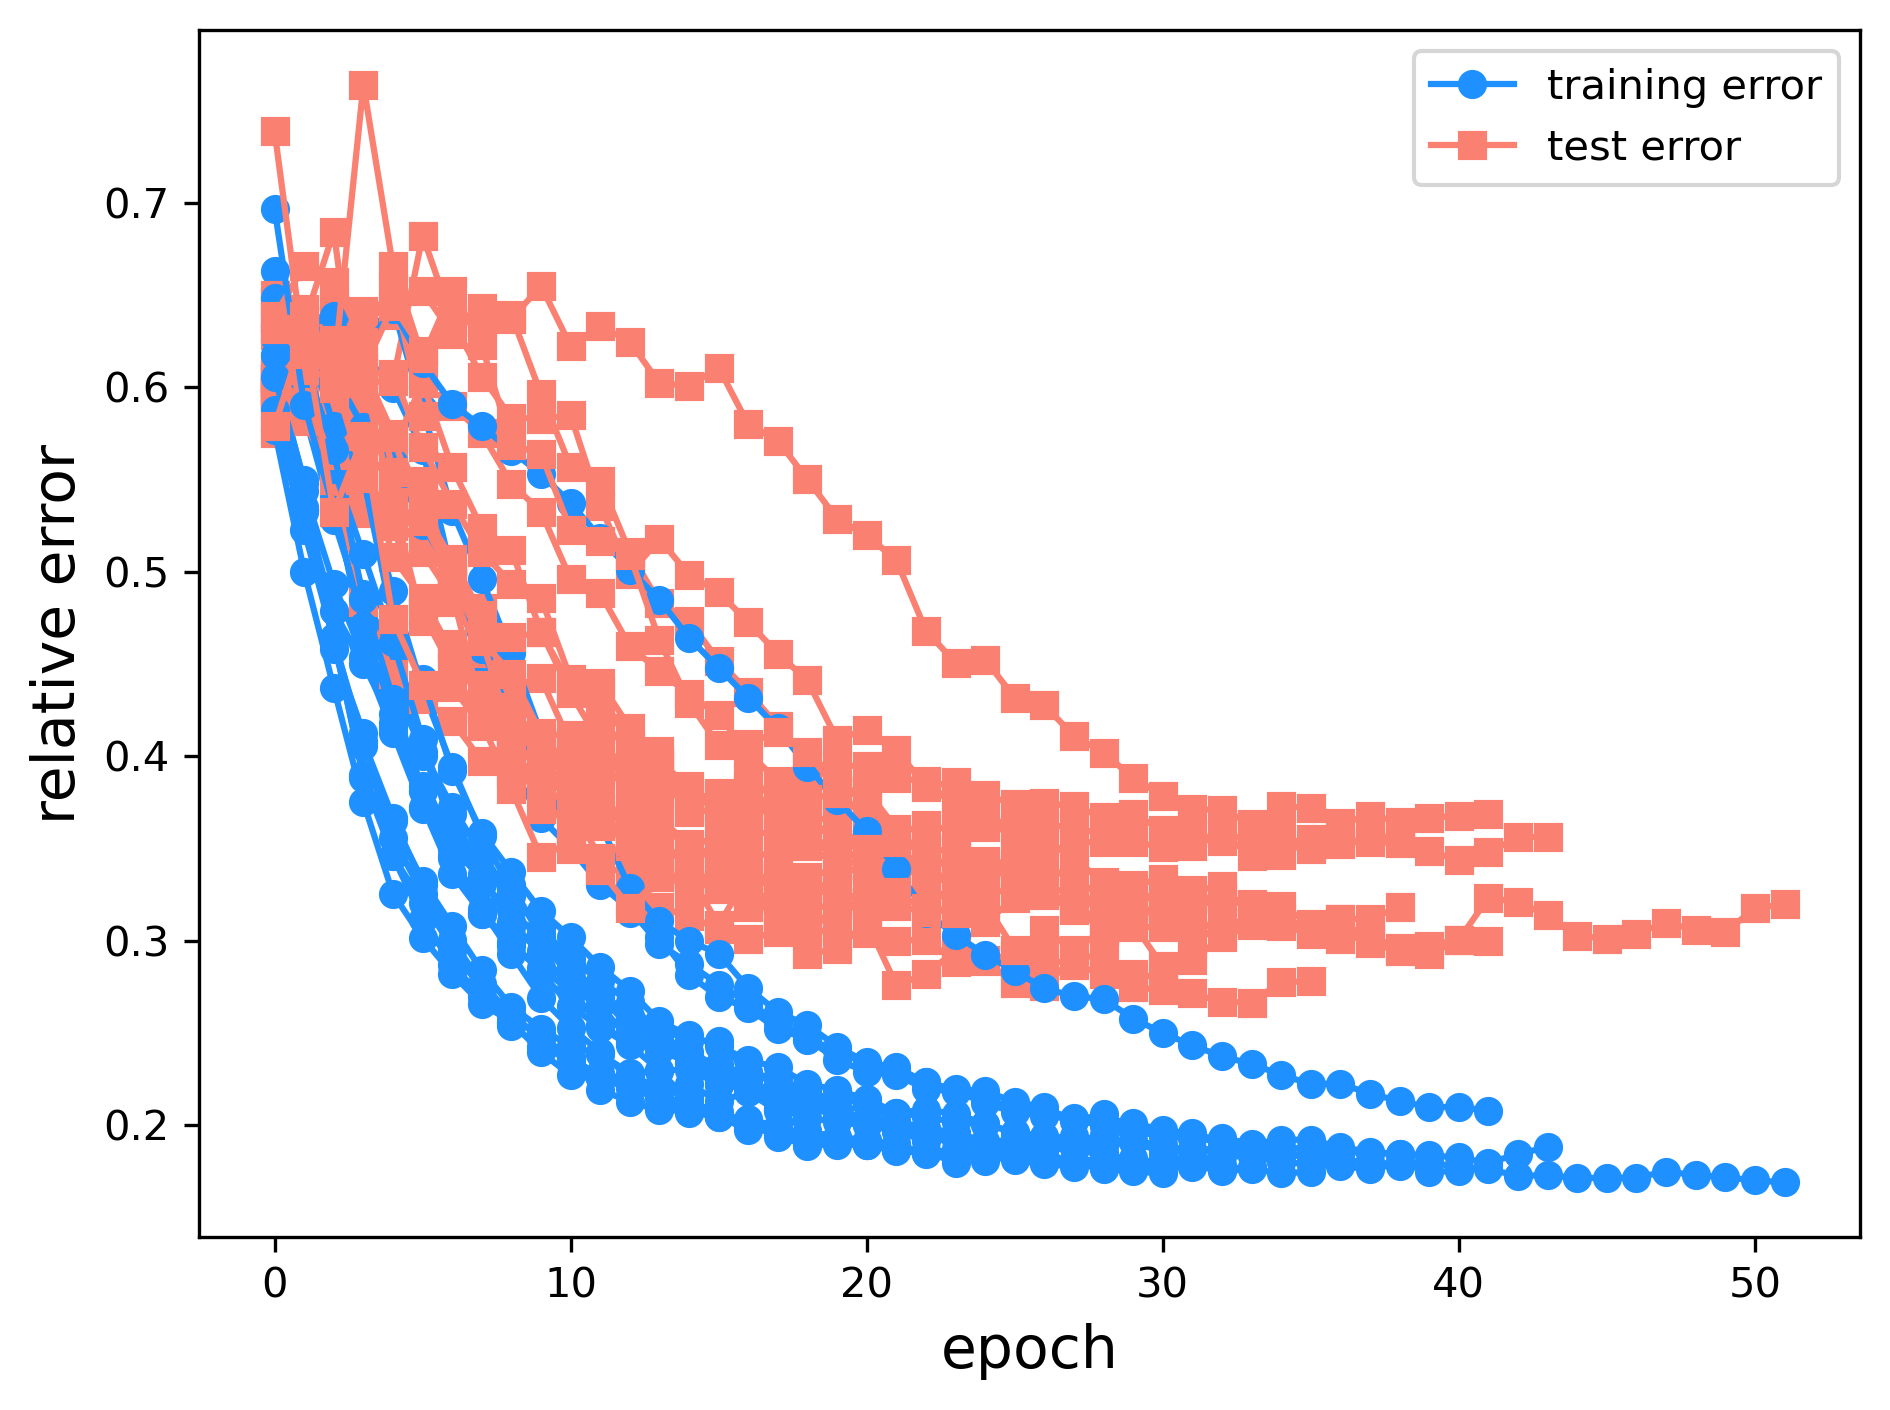

In [17]:
# plot the relative DAS training and test error for the last replica network
plot_errors(results_das)

### Get training results

In [18]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. 

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


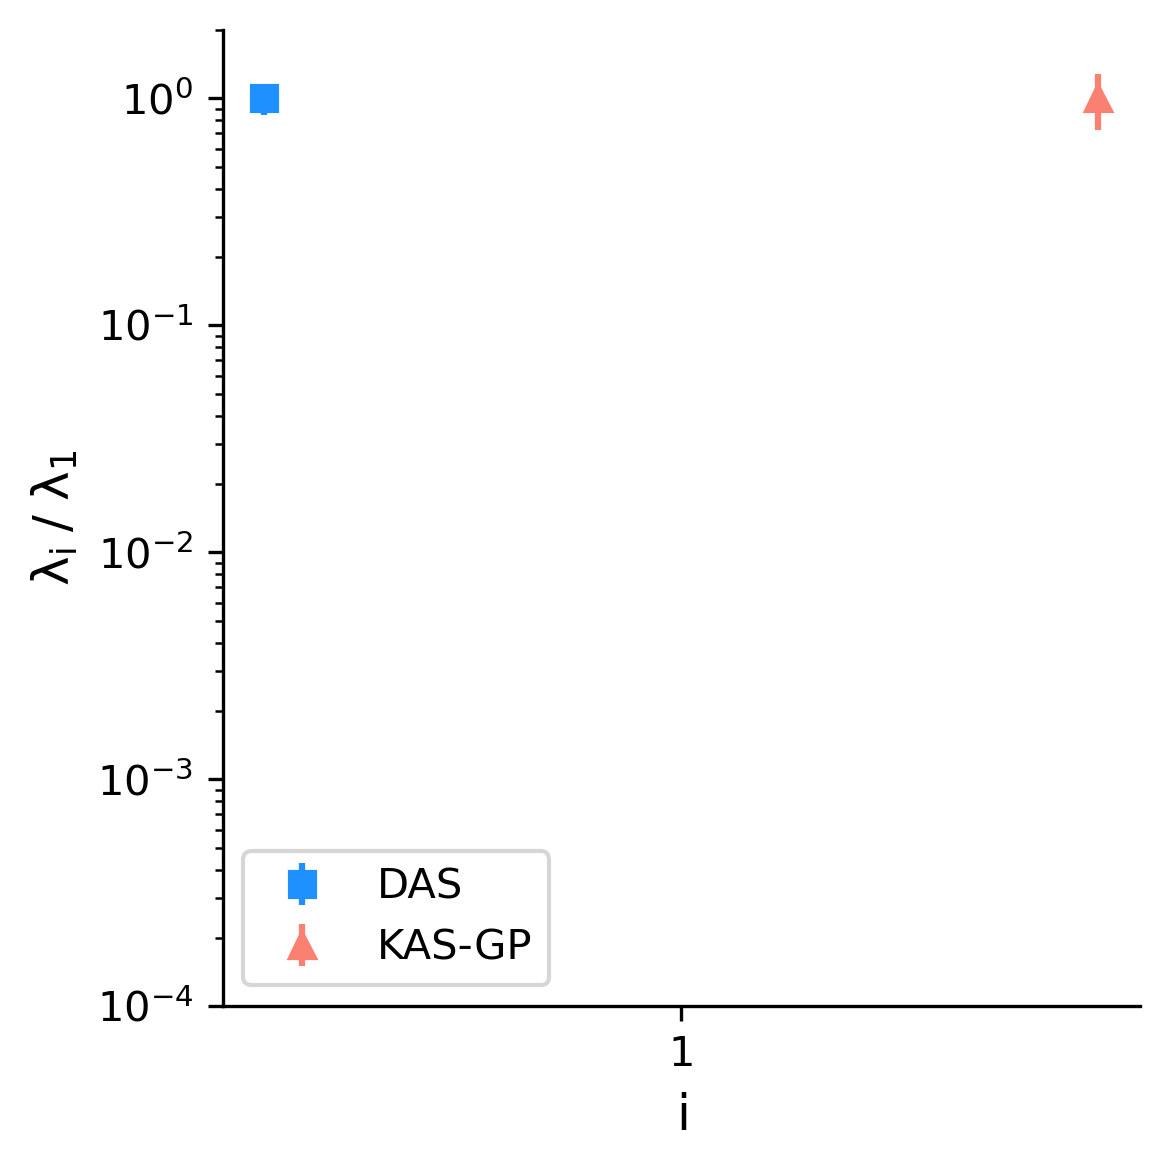

In [19]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_ties.csv')
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             yerr = GP_std[0:n_vals], fmt='^', color='salmon', label='KAS-GP')
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/ties_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [20]:
# run the DAS surrogate a a number of random inputs locations
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])


In [21]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T


### Recreate the active subspace plot

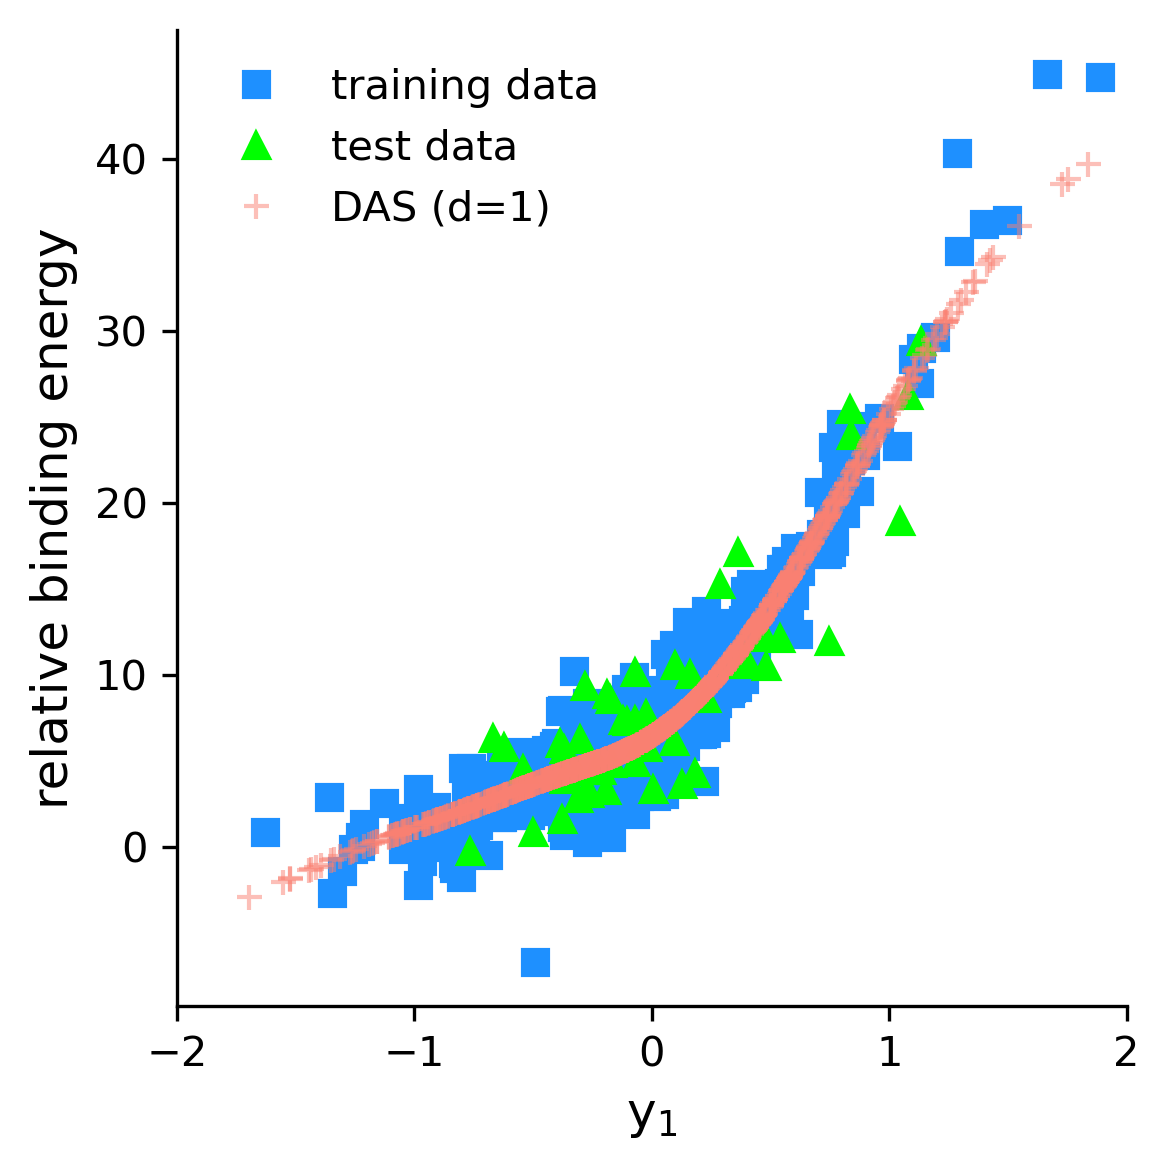

In [22]:
#########################
# plot active subspaces #
#########################
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111, xlim=[-2, 2])
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_ylabel(r'relative binding energy', fontsize=12)
ax.plot(y_das_train[:,0], samples_train, 's', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', color='lime', label='test data') 
ax.plot(y_val_das[:,0], das_samples_pred, '+', color='salmon', label='DAS (d=%d)' % d, alpha=0.5)
leg = ax.legend(loc=0, frameon=False)
leg.set_draggable(True)
sns.despine(top=True)
plt.tight_layout()
plt.savefig('./images/ties_surrogate_d%d.png' % (d, ))


### Recreate the global-derivative based sensitivity plots

In [23]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_ties.csv')

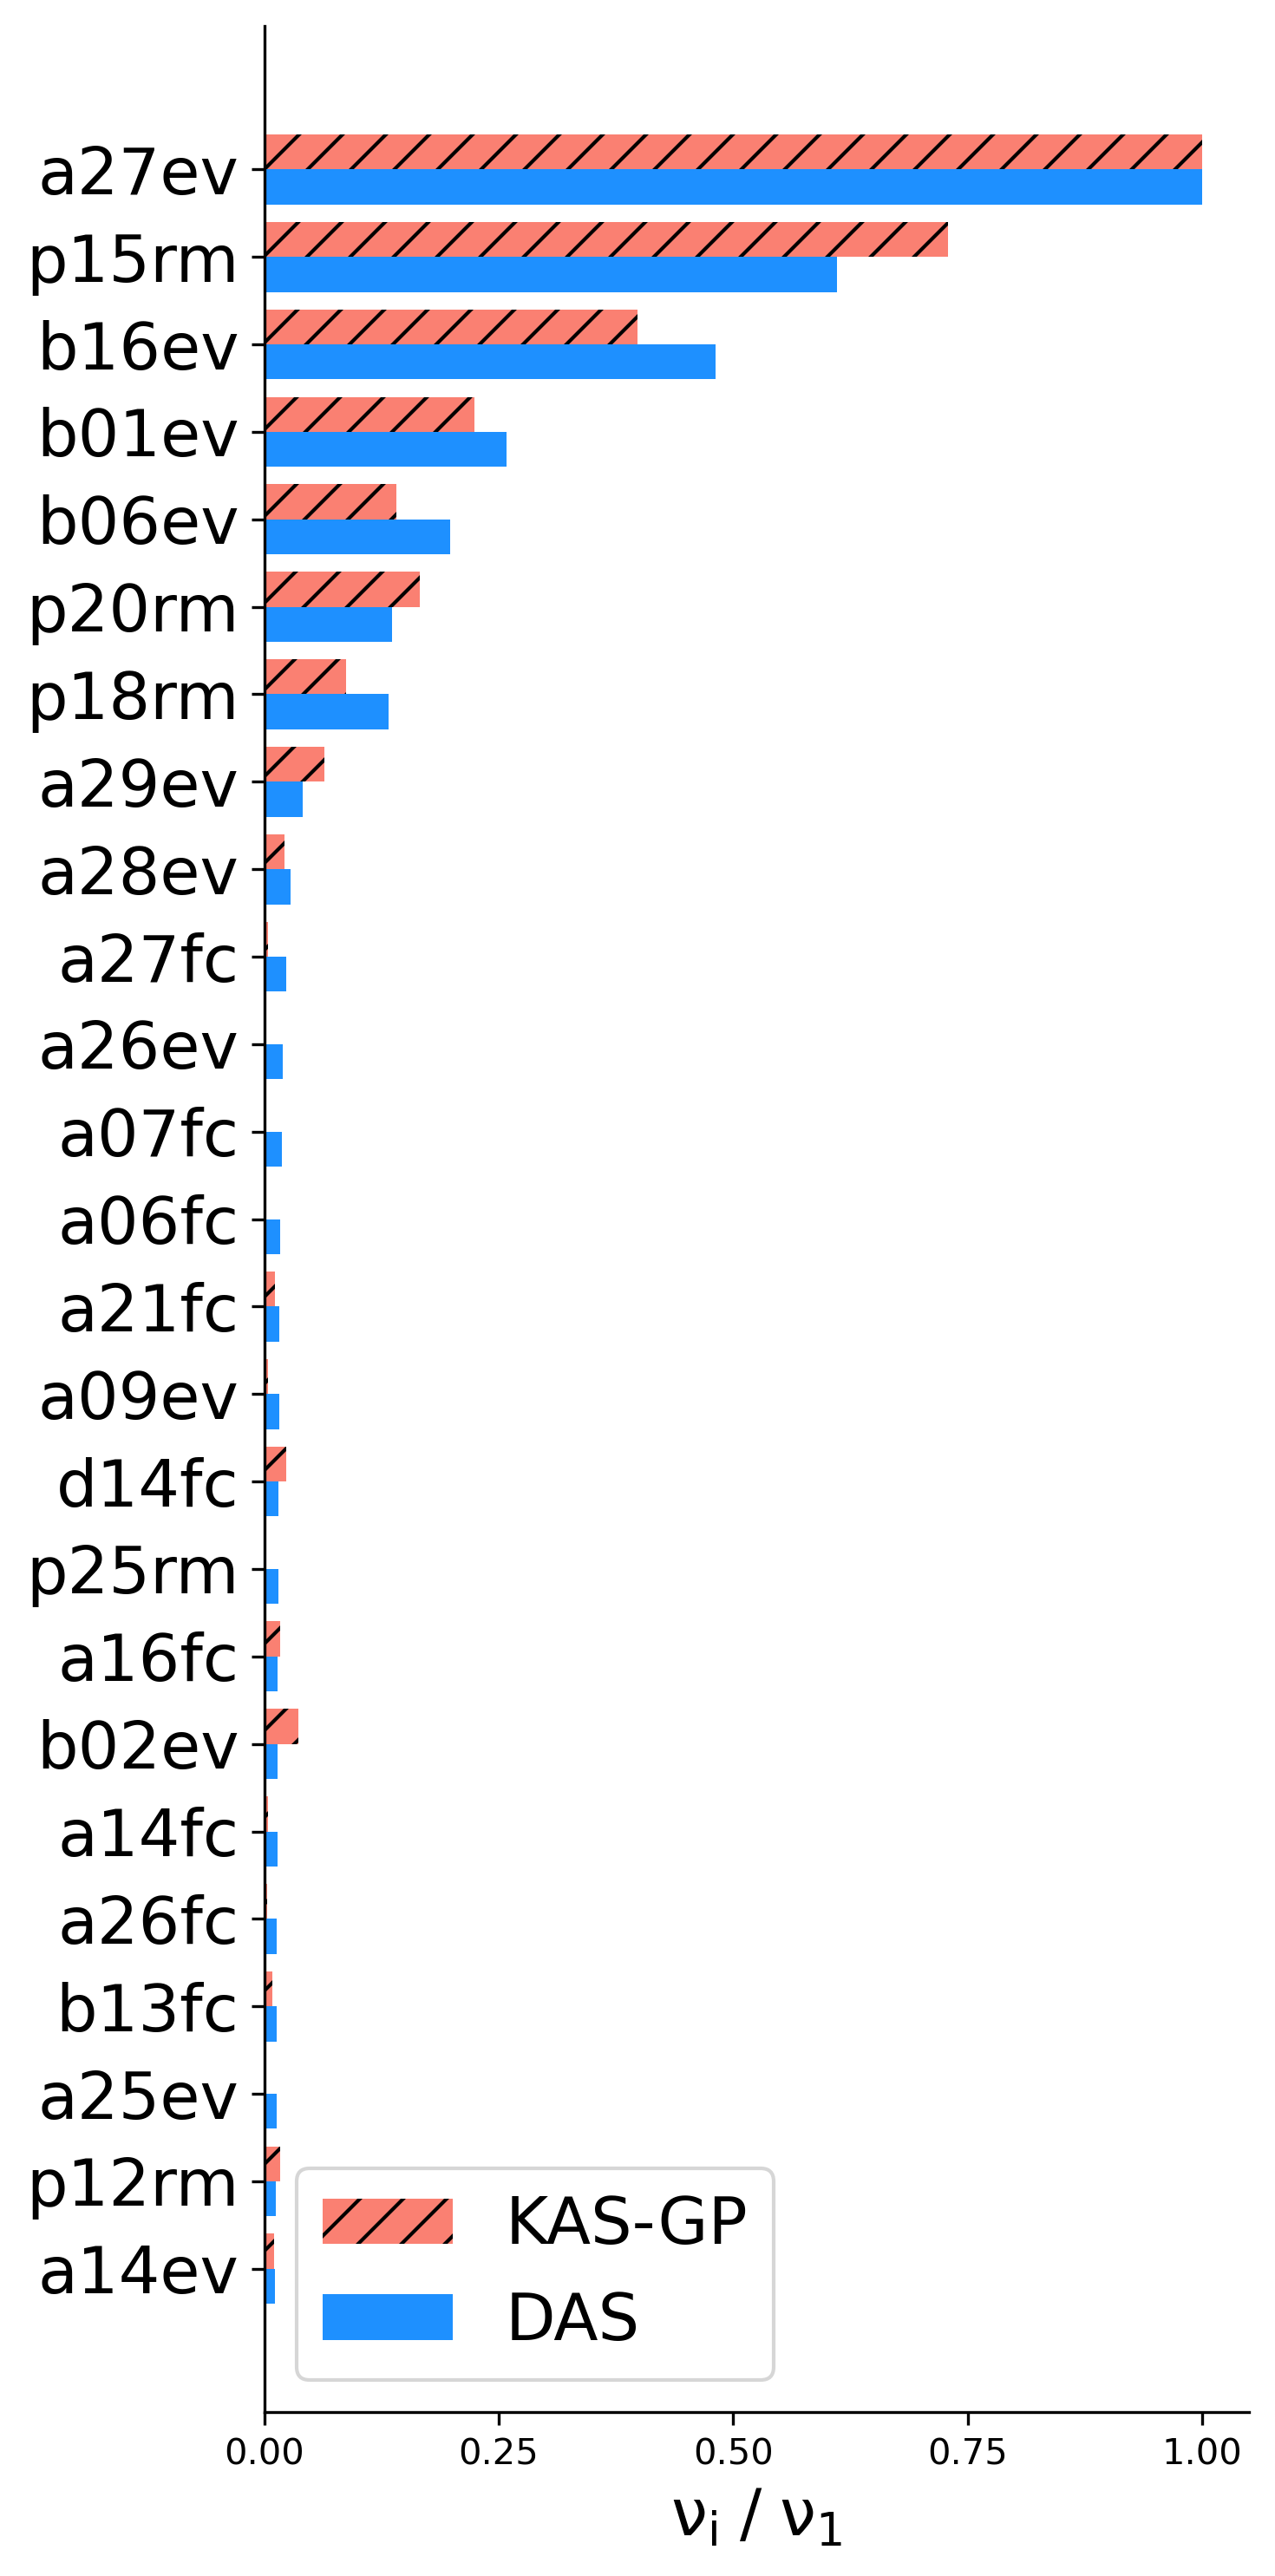

In [24]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


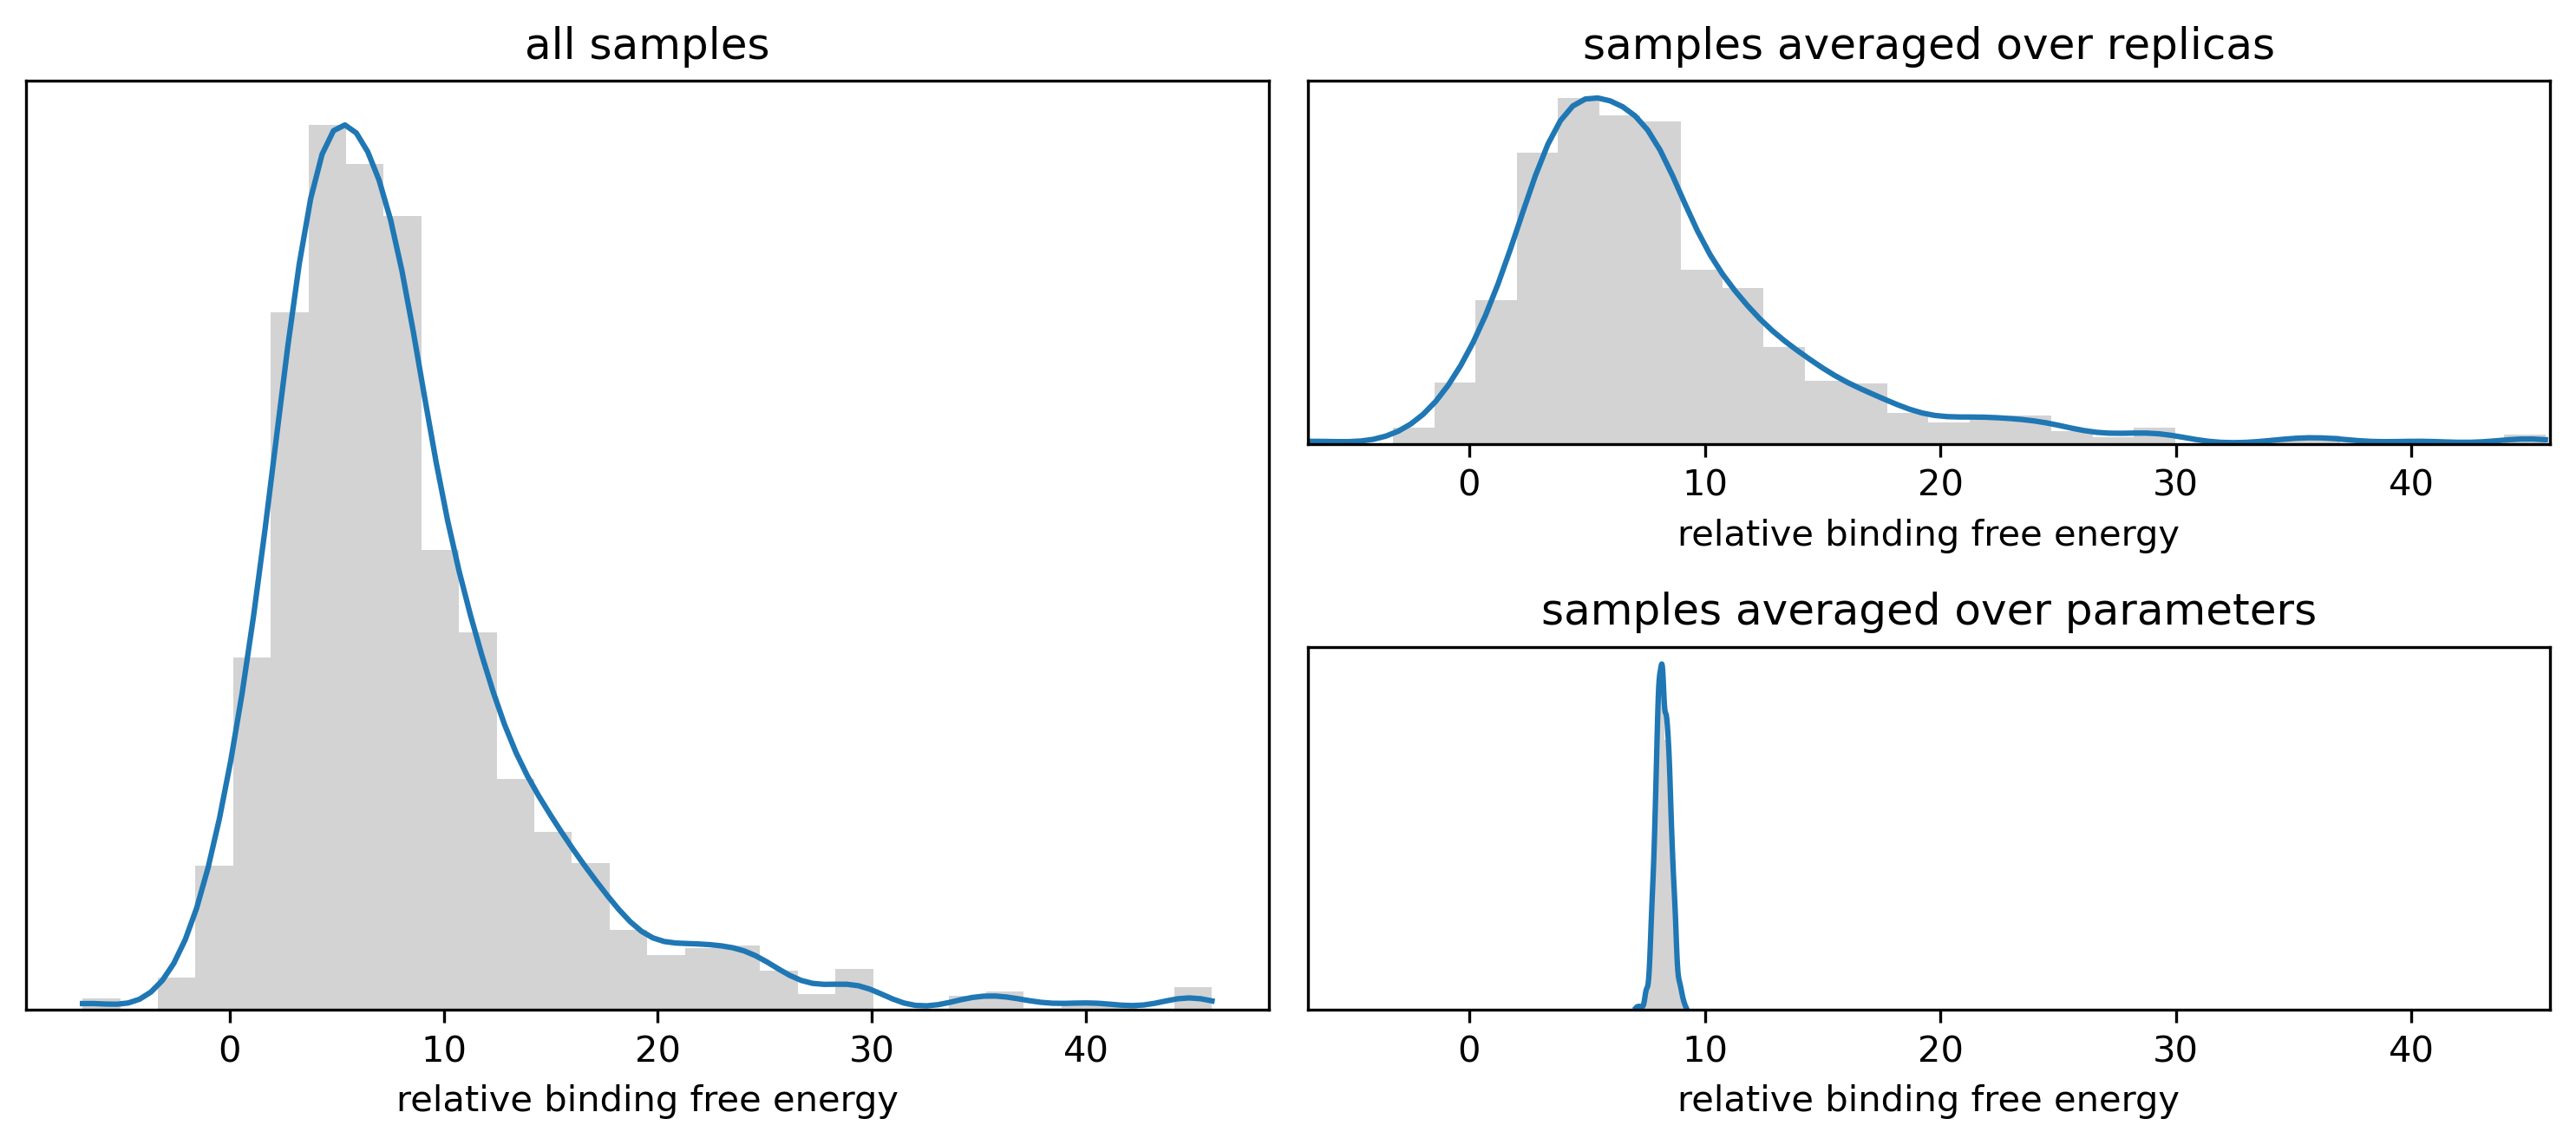

In [25]:
plot_dist(output, 'relative binding free energy')

### (Non-Gaussian) stats with bootstrapping

In [26]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:19<00:00, 718.76it/s]


In [27]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [31]:
print("Mean: %.2f (%.2f/%.2f)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2f (%.2f/%.2f)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.2f/%.2f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: 8.23 (8.01/8.45)
Std dev: 6.70 (6.38/7.01)
Skew: 1.95 (1.77/2.11)
Kurt: 5.94 (4.91/6.87)
N_samples = 2440
